In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skmultilearn.adapt import MLkNN
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.dataset import available_data_sets
from skmultilearn.dataset import load_dataset
from matplotlib import pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

#  Particle.py

In [2]:
class Particle:
    
    def __init__(self, length, pos_max, pos_min, vel_max, vel_min, w, c1, c2, problem):
        self.length = length
        self.pos_max = pos_max
        self.pos_min = pos_min
        self.vel_max = vel_max
        self.vel_min = vel_min
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.problem = problem

#         self.position = np.random.rand(length)*(pos_max-pos_min)  # TODO 0118
        self.position = pos_min + np.random.rand(length)*(pos_max-pos_min)
        self.velocity = np.zeros(length)
        self.fitness = self.problem.worst_fitness()

        self.pbest_pos = np.zeros(length)
        self.pbest_fit = self.problem.worst_fitness()

        self.gbest_pos = np.zeros(length)
        self.gbest_fit = self.problem.worst_fitness()

    def update(self):
        # Update velocity
        self.velocity = self.w * self.velocity + \
            self.c1 * np.random.rand(self.length) * (self.pbest_pos - self.position) + \
            self.c2 * np.random.rand(self.length) * (self.gbest_pos - self.position)

        self.velocity[self.velocity < self.vel_min] = self.vel_min
        self.velocity[self.velocity > self.vel_max] = self.vel_max

        # update position
        self.position = self.position + self.velocity
        self.position[self.position < self.pos_min] = self.pos_min
        self.position[self.position > self.pos_max] = self.pos_max

In [3]:
# Modified 0120
# Add new_w

class Swarm:

    def __init__(self, n_particles, length, pos_max, pos_min, vel_max, vel_min, problem, n_iterations):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.problem = problem

        w = 0.8
        c1 = 1.46
        c2 = 1.46
        self.population = [Particle(length = length, 
                                    pos_max = pos_max, pos_min = pos_min, 
                                    vel_max = vel_max, vel_min = vel_min, 
                                    w = w, c1 = c1, c2 = c2, problem = problem)  
                           for _ in range(n_particles)]

    def iterate(self):

        for i in range(self.n_iterations):
            new_w = 0.9 - i * (0.9 - 0.4) / self.n_iterations  # modified 0120
            
            print('Iterate ', i, end = '  ')
            gbest_fit = self.population[0].gbest_fit
            gbest_index = 0
            gbest_updated = False
            print('gbest value is ', gbest_fit)
            
            for index, particle in enumerate(self.population):
                # Evaluate each particle, update pbest
                particle.w = new_w  # modified 0120
                particle.fitness = self.problem.fitness(particle.position)  

                if self.problem.is_better(particle.fitness, particle.pbest_fit):
                    particle.pbest_fit = particle.fitness
                    particle.pbest_pos = np.copy(particle.position)

                if self.problem.is_better(particle.pbest_fit, gbest_fit):
                    gbest_fit = particle.pbest_fit
                    gbest_index = index
                    gbest_updated = True

            if gbest_updated:
                for particle in self.population:
                    particle.gbest_fit = self.population[gbest_index].pbest_fit
                    particle.gbest_pos = np.copy(
                        self.population[gbest_index].pbest_pos)

            # now update particle position:
            for particle in self.population:
                particle.update()

        return self.population[0].gbest_pos, self.population[0].gbest_fit

#  Problem.py

In [4]:
class Problem:
    def __init__(self, minimize):
        self.minimize = minimize

    def fitness(self, solution):
        return 1
    
    def is_better(self, first, second):
        if self.minimize:
            return first < second
        else:
            return first > second

    def worst_fitness(self):
        if self.minimize:
            return float('inf')
        else:
            return float('-inf')

In [5]:
class FS(Problem):

    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        clf = KNN()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        return acc

In [6]:
# Standard PSO
# Fitness is MLKNN classification hamming loss.

class FS_ML(Problem):
    
    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        clf = MLkNN(k=3)
        scaler = StandardScaler()
#         scaler = MinMaxScaler()
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        hamming_losses = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            ham = hamming_loss(y_test, y_pred)
            hamming_losses += ham
        
        return hamming_losses/n_splits    

In [8]:
# Super label PSO
# Fitness is use super+sub classification hamming loss

class FS_ML_super(Problem):
    
    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)
            
        hamming_losses = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
            y_test_pred, y_test = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df)
            
        
            ham = hamming_loss(y_test, y_test_pred)
            hamming_losses += ham
        
        return hamming_losses/n_splits

In [5]:
# Super label PSO
# Fitness is use super+sub classification f1 score micro 
# modified 0120 add no_cls

class FS_ML_super(Problem):
    
    def __init__(self, minimize, X, y, no_cls):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.no_cls = no_cls   # modified 0120 add no_cls
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        no_cls = self.no_cls  # modified 0120 add no_cls
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)
            
        f1_mics = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
            y_test_pred, y_test = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
            
        
            f1_mic = f1_score(y_test, y_test_pred, average = 'micro')
            f1_mics += f1_mic
        
        return f1_mics/n_splits

In [5]:
# Super label PSO
# Fitness is use super+sub classification f1 score micro 
# modified 0120 add no_cls

class FS_ML_super(Problem):
    
    def __init__(self, minimize, X, y, no_cls):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.no_cls = no_cls   # modified 0120 add no_cls
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        no_cls = self.no_cls  # modified 0120 add no_cls
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)
            
        f1_mics = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
            y_test_pred, y_test = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
            
        
            f1_mic = f1_score(y_test, y_test_pred, average = 'micro')
            f1_mics += f1_mic
        
        return f1_mics/n_splits

# Super_labels.py

In [6]:
# In each subcgroup(cluster), get label indexes 

def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [7]:
# Convert each subgroup's labels(binary nparray) into super label(list)
# If all labels are 0, super label is 0; otherwise, super label is assigned to 1
# Return converted y_super_label columns.
# n_column equals to n_clstuer.

def convert(subgroup_label):
    super_ = []
    subgroup_label_array = subgroup_label.to_numpy()
    rows = subgroup_label.shape[0]
    columns = subgroup_label.shape[1]
    for row in range(rows):
        s = 0
        for column in range(columns):
            if subgroup_label_array[row][column] == 1:
                s = 1
                break
        super_.append(s)
    return super_

In [8]:
# Convert original y labels into y_super labels
# subgroup_labels are dataframe with original labels + super labels

def label_convert(y_train_, no_cls):  # Here y is dataframe
    
    subgroups = []
    super_labels = []
    kmeans = KMeans(n_clusters=no_cls, random_state=0).fit(y_train_.T)
    dict_clst_col = dict()  # dictionary to record key(cluster index) and value(cluster columns)
    
    for i in range(no_cls):
        cluster = ClusterIndicesNumpy(i, kmeans.labels_)  # Column numbers(indexes) of all the labels in each cluster
        dict_clst_col[i] = cluster
        subgroup_label = y_train_.iloc[:,cluster]   # Get all the original labels from cluster, dataframe form
        s = pd.DataFrame(convert(subgroup_label), columns = ['s'+ str(i)])   # Convert original labels to a column super label
        super_labels.append(s)
        subgroup_label['s' + str(i)] = s   # Concat s into subgroup
        subgroups.append(subgroup_label)        
        
    y_s = pd.concat(super_labels, axis=1)   # Combine all super label columns, as orginal y converted to super_label y, the target
    y_s = y_s.to_numpy()

    return y_s, subgroups, dict_clst_col

In [9]:
# After split, indexes of X_train, X_test and y_train, y_test will be discorder, aka not ascending any more.
# If index disorder, will be tricky to process index, e.g. zero_idx
# Need to reorder index first.

def convert_index(X_train, X_test, y_train, y_test):
    
    X_train_ = X_train.reset_index(drop=True)
    y_train_ = y_train.reset_index(drop=True)
    X_test_ = X_test.reset_index(drop=True)
    y_test_ = y_test.reset_index(drop=True)
    
    return X_train_, X_test_, y_train_, y_test_

When doing super and sub classification on training set, k-fold is not neccesary. 
Only the classifiers are required.

In [10]:
# Get trained super_classifier

def super_classifier(X_train_, y_train_, no_cls):
    
    clf = MLkNN(k=3)

    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_train_scaled_1 = scaler_1.fit_transform(X_train_)
    X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
#     scaler = StandardScaler()
#     X_train_ = scaler.fit_transform(X_train_)
#     X_train_ = MinMaxScaler().fit_transform(X_train_)
    y_s, subgroups, dict_clst_col = label_convert(y_train_, no_cls)
    clf.fit(X_train_scaled_2, y_s)
#     clf.fit(X_train_, y_s)
    
    return clf

In [11]:
# For each subgroup, collect all the zero super labels
# The len of total_zeros is the number of subgroups, also the number of super labels

def zeros(y_s):

    total_zeros = []
    for i in range(y_s.shape[1]):     # number of super labels
        idx_zeros = []
        for j in range(y_s.shape[0]):   # number of instances
            if y_s[j][i] == 0:
                idx_zeros.append(j)
        total_zeros.append(idx_zeros)
        
    return total_zeros

In [12]:
# In each subgroup, if a particular row of y_s is zero, the corresponding X features also needs to be removed.
# For each subgroup, get the indexes of zeros in one y_s, and remove these same indexes from X feature instances.
# Each subgroup contains its own X, means different subgroup contain diffenrent number of instances
# Collect each removed X and return.

def remove_zeros(X, y_s):  # y_s is ndarray
    total_zeros = zeros(y_s)
    Xs = []
    for idx_zeros in total_zeros:
        X_ = pd.DataFrame(X).drop(idx_zeros)   
        Xs.append(X_)  
    return Xs

From original X and y, compute super label y(y_s), which actually comes from true y.
Each subgroup contains original y labels + y_s label.
Check each y_s, if 0, than remove the whole line, which means remove its corresponding original labels, and its X.
So the remaining of original labels, as well as X of each subgroup are different, since indexes of zeros in each y super label are different.

def sub_classification is for each subgroup, train X_(X remove y_s's zero indexes) and y_(y sub original labels remove y_s's zero indexes).
After training, collect all sub-clfs and Xs.

In [13]:
# Get trained sub classifiers

def sub_classifiers(X_train_, y_train_, no_cls):
    
    clfs = []
    n_sub_labelses = []
    y_s, subgroups, dict_clst_col = label_convert(y_train_, no_cls)   # y_super labels, converted from original y labels (target)
    total_zeros = zeros(y_s)
#     scaler = StandardScaler() 
#     scaler = MinMaxScaler()
    scaler_1 = StandardScaler() 
    scaler_2 = MinMaxScaler()
    Xs = remove_zeros(X_train_, y_s)
    
    for subgroup, idx_zeros, X in zip(subgroups,total_zeros, Xs):
                                                 # Have different X, because idx of zero are different
        y_ = subgroup.drop(idx_zeros)            # Drop all the zero instances, both in X and y, aka X_, y_ 
        y_ = y_.drop(y_.columns[-1:], axis = 1)  # Remove the s label
        n_sub_labels = subgroup.shape[1]-1
        n_sub_labelses.append(n_sub_labels)
        
        X_scaled_1 = scaler_1.fit_transform(X)
        X_scaled_2 = scaler_2.fit_transform(X_scaled_1)
#         X_ = scaler.fit_transform(X)
        clf = MLkNN(k=3)
#         clf.fit(X_, y_.to_numpy())
        clf.fit(X_scaled_2, y_.to_numpy())
        
        clfs.append(clf)

    return clfs, n_sub_labelses

Now already gained clf, which is classifier for super classification, and clfs which are for all the sub-classifications.
Then will apply clf and clfs on training set, to see the training_loss, and then apply on test set, to get test_loss.
Finally, compare.

1. Apply clf, clfs, Xs on training set.

In [14]:
# Do super classification on dataset

def super_classification(clf_super, X_test_):
#     scaler = StandardScaler()
    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_test_scaled_1 = scaler_1.fit_transform(X_test_)
    X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)
#     X_test_scaled = scaler.fit_transform(X_test_)
#     X_test_scaled = MinMaxScaler().fit_transform(X_test_)
#     y_test_s_pred = clf_super.predict(X_test_scaled).toarray()   # Predicted super labels, will be passed into def zeros().
    y_test_s_pred = clf_super.predict(X_test_scaled_2).toarray()
    return y_test_s_pred

In [15]:
# Do sub-classification on sub-datasets (original X + subgroup original labels)

def sub_classification(clfs, n_sub_labelses, X_test_, y_test_s_pred):

    total_test_zeros = zeros(y_test_s_pred)    # Based on predicted super label, compute which are zeros in each subgroup
    
    X_tests = remove_zeros(X_test_, y_test_s_pred)  # Remove zeros in each subgroup in X
    
    y_test_sub_preds = []
#     scaler = StandardScaler() 
#     scaler = MinMaxScaler()
    scaler_1 = StandardScaler() 
    scaler_2 = MinMaxScaler()
    for clf, X_test in zip(clfs, X_tests):
        if len(X_test.axes[0]) == 0:  # based on corrrespanding y_s_pred column, the y_labels in column are all zeros
            y_test_sub_pred = None  # so when remove zeros in X_test, n_rowsof X-test is 0, aka no intances to predict
            y_test_sub_preds.append(y_test_sub_pred)
        else:
#             X_scaled = scaler.fit_transform(X_test)
            X_scaled_1 = scaler_1.fit_transform(X_test)
            X_scaled_2 = scaler_2.fit_transform(X_scaled_1)
#             y_test_sub_pred = clf.predict(X_scaled)   # y_test_sub_pred is sparse matrix
            y_test_sub_pred = clf.predict(X_scaled_2)
            y_test_sub_preds.append(y_test_sub_pred)
        
    return total_test_zeros, y_test_sub_preds    # total_test_zeros, y_test_sub_labels are lists

After super and sub-classifications are done on test/validation dataset, the next step is to revert and rebuild all the predicted sub-labels together. 
The predicted subgroups do not contain all the original instances, coz those all-zeros instances are removed before sub-classification. So when doing revert, we need to find out which instances are all-zeros(those predicted super-predicted are zero), these can be reverted to [0,0,0,...].
If the super-predicted label is not 0, then this predicted instance's subgroup labels are in coreesponding y_sub_pred. 

len(total_zeros) is number of subgroups, aka number of columns for super_y_labels
for each subgroup, y.shape[0] is the rows, aka instances in original y, 
if index of the instance is included in column in total_zeros, that means when revert to original labels, we can impute all the subgroup labels of this instance to all zeros

How to impute the zero super label's corresponding sub-labels to zeros? We need to know how many sub-labels in each cluster. That is how many labels in each y_sub_pred

In [16]:
# Fill out zeros back into each y_sub_pred

def fill_zeros(total_test_zeros, y_test_sub_preds, y_test_, n_sub_labelses):
    total_filled_preds = []
    
    for i in range(len(total_test_zeros)):   # number of columns of y_super
        labels = []     
        if y_test_sub_preds[i] == None:
            for j in range(y_test_.shape[0]):   
                labels.append(np.zeros(n_sub_labelses[i], dtype=np.int64))   # Create all zero list, then list of list, append
        else:
            y_test_sub_pred_np = y_test_sub_preds[i].toarray()     # y_test_sub_pred is sparse matrix, convert to nparray
            no_sublabels = y_test_sub_pred_np.shape[1]
            for j in range(y_test_.shape[0]):   # original y_test's rows
                if j in total_test_zeros[i]:   
                    labels.append(np.zeros(no_sublabels, dtype=np.int64))                                          
                else:
                    label = y_test_sub_pred_np[0]             
                    labels.append(label)
                    y_test_sub_pred_np = np.delete(y_test_sub_pred_np, [0], axis = 0)
        total_filled_preds.append(labels)  
        
    return total_filled_preds

In [17]:
# sort the order of y_test_preds, aka revert to original order as y_test's columns(before clustering)
# Clusters are not neccessarily equal, so could convert total_filled_preds to np.array

def sort_preds(total_filled_preds, y_train_, no_cls):
    
    y_s, subgroup, dict_clst_col = label_convert(y_train_, no_cls)
    y_test_sub_preds = []
    for i in range(len(total_filled_preds)):
        np_total_filled_pred = np.array(total_filled_preds[i])
        y_test_sub_preds.append(pd.DataFrame(np_total_filled_pred, columns = dict_clst_col[i]))
    y_test_pred = pd.concat(y_test_sub_preds, axis = 1)
    y_test_pred_t = y_test_pred.T
    y_test_pred_t_sorted = y_test_pred_t.sort_index(ascending=True)
    y_test_pred_sorted = y_test_pred_t_sorted.T

    return y_test_pred_sorted

In [18]:
# Based on splited X_train, y_train, calculate the y_test_pred on x_test

def calc_preds(X_train, y_train, X_test, y_test, no_cls):
    
    X_train_, X_test_, y_train_, y_test_ = convert_index(X_train, X_test, y_train, y_test)
    
    clf_super = super_classifier(X_train_, y_train_, no_cls)
    clfs_sub, n_sub_labelses = sub_classifiers(X_train_, y_train_, no_cls)
    y_test_s_pred = super_classification(clf_super, X_test_)
    total_test_zeros, y_test_sub_preds = sub_classification(clfs_sub, n_sub_labelses, X_test_, y_test_s_pred)
    total_filled_preds = fill_zeros(total_test_zeros, y_test_sub_preds, y_test_, n_sub_labelses)
    y_test_pred_sorted = sort_preds(total_filled_preds, y_train_, no_cls)
    
    return y_test_pred_sorted, y_test_

#  Simple_super.py

In [50]:
# In each subcgroup(cluster), get label indexes 

def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [144]:
# Convert each subgroup's labels(binary nparray) into super label(list)
# If all labels are 0, super label is 0; otherwise, super label is assigned to 1

def convert(subgroup_label):
    super_ = []
    subgroup_label_array = subgroup_label.to_numpy()
    rows = subgroup_label.shape[0]
    columns = subgroup_label.shape[1]
    for row in range(rows):
        s = 0
        for column in range(columns):
            if subgroup_label_array[row][column] == 1:
                s = 1
                break
        super_.append(s)
    return super_

In [292]:
# Convert original y labels into y_super labels
# subgroup_labels are dataframe with original labels + super labels

def label_convert_simple(y, no_cls):  # Here y is dataframe
    
    super_labels = []
    kmeans = KMeans(n_clusters=no_cls, random_state=0).fit(y.T)
    
    for i in range(no_cls):
        cluster = ClusterIndicesNumpy(i, kmeans.labels_)  # Column numbers(indexes) of all the labels in each cluster
        subgroup_label = y.iloc[:,cluster]   # Get all the original labels from cluster, dataframe form
        s = pd.DataFrame(convert(subgroup_label), columns = ['s'+ str(i)])   # Convert original labels to a column super label
        super_labels.append(s)    
        
    y_s = pd.concat(super_labels, axis=1)   # Combine all super label columns, as orginal y converted to super_label y, the target
    y_s = y_s.to_numpy()

    return y_s

In [309]:
# Get trained super_classifier

def super_classifier(X_train, y_train, no_cls):
    
    clf_super = MLkNN(k=3)

    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_train_scaled_1 = scaler_1.fit_transform(X_train)
    X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
    clf_super.fit(X_train_scaled_2, y_train_s)
    
    return clf_super

In [294]:
# Do super classification on dataset

def super_classification(clf_super, X_test):

    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_test_scaled_1 = scaler_1.fit_transform(X_test)
    X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)
    y_test_s_pred = clf_super.predict(X_test_scaled_2).toarray()
    
    return y_test_s_pred

In [18]:
# Based on splited X_train, y_train, calculate the y_test_pred on x_test

def calc_preds(X_train, y_train, X_test, y_test, no_cls):
    
    X_train_, X_test_, y_train_, y_test_ = convert_index(X_train, X_test, y_train, y_test)
    
    clf_super = super_classifier(X_train_, y_train_, no_cls)
    clfs_sub, n_sub_labelses = sub_classifiers(X_train_, y_train_, no_cls)
    y_test_s_pred = super_classification(clf_super, X_test_)
    total_test_zeros, y_test_sub_preds = sub_classification(clfs_sub, n_sub_labelses, X_test_, y_test_s_pred)
    total_filled_preds = fill_zeros(total_test_zeros, y_test_sub_preds, y_test_, n_sub_labelses)
    y_test_pred_sorted = sort_preds(total_filled_preds, y_train_, no_cls)
    
    return y_test_pred_sorted, y_test_

In [295]:
X, y, feature_names, label_names = load_dataset('birds', 'undivided')
X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

birds:undivided - exists, not redownloading


In [296]:
y = pd.DataFrame(y)
X = pd.DataFrame(X)

In [297]:
no_cls = 4

In [298]:
kmeans = KMeans(n_clusters = no_cls, random_state = 42).fit(y.T)

In [300]:
y_s = label_convert_simple(y, no_cls)

In [302]:
X_train, X_test, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.33, random_state=42)

In [310]:
clf_super = super_classifier(X_train, y_train, no_cls)

In [314]:
scaler_1 = StandardScaler()
scaler_2 = MinMaxScaler()
X_test_scaled_1 = scaler_1.fit_transform(X_test)
X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)
y_test_s_pred = clf_super.predict(X_test_scaled_2).toarray()

In [315]:
hamming_loss(y_test_s, y_test_s_pred)

0.11619718309859155

In [136]:
kmeans_whole = KMeans(n_clusters = no_cls, random_state = 42).fit(y.T)
kmeans_train = KMeans(n_clusters = no_cls, random_state = 42).fit(y_train_.T)
kmeans_test = KMeans(n_clusters = no_cls, random_state = 42).fit(y_test_.T)

In [137]:
for i in range(no_cls):
    print(ClusterIndicesNumpy(i, kmeans_whole.labels_))

[0 1 2 5]
[3 4]


In [138]:
for i in range(no_cls):
    print(ClusterIndicesNumpy(i, kmeans_train.labels_))

[0 1 2 5]
[3 4]


In [139]:
for i in range(no_cls):
    print(ClusterIndicesNumpy(i, kmeans_test.labels_))

[3 4]
[0 1 2 5]


In [196]:
# # After split, indexes of X_train, X_test and y_train, y_test will be discorder, aka not ascending any more.
# # If index disorder, will be tricky to process index, e.g. zero_idx
# # Need to reorder index first.

# def convert_index_simple(X_train, X_test):
    
#     X_train_ = X_train.reset_index(drop=True)
#     X_test_ = X_test.reset_index(drop=True)
    
#     return X_train_, X_test_

#  Util.py

In [16]:
# Read arff file.

def read_arff(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split()[1])
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header=None)
        df.columns = header
    return df

In [19]:
# K-fold only accept X, y in numpy form, and return X_train, X_test, y_train, y_test in each loop(split).
# Convert X_train, X_test, y_train, y_test from numpy to dataframe, for super_label calculation call.

def Convert_to_df(X_train, X_test, y_train, y_test):
    
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    y_train_df = pd.DataFrame(y_train)
    y_test_df = pd.DataFrame(y_test)
    
    return X_train_df, X_test_df, y_train_df, y_test_df

# Main.py

In [17]:
set([x[0] for x in available_data_sets().keys()])

{'Corel5k',
 'bibtex',
 'birds',
 'delicious',
 'emotions',
 'enron',
 'genbase',
 'mediamill',
 'medical',
 'rcv1subset1',
 'rcv1subset2',
 'rcv1subset3',
 'rcv1subset4',
 'rcv1subset5',
 'scene',
 'tmc2007_500',
 'yeast'}

In [25]:
datasets = ['CAL500', 'flags']
n_featureses = [68, 19]
n_labels = [174, 7]

In [18]:
datasets_small = ['emotions', 'scene']
datasets_medium = ['yeast', 'birds', 'genbase']
datasets_large = ['medical', 'enron', 'bibtex', 'Corel5k']
datasets_list = [datasets_small, datasets_medium, datasets_large]
# datasets_list = [datasets_medium]

no_clses_small = [2, 4]
no_clses_medium = [2, 4, 6, 8]
no_clses_large = [2, 4, 6, 8, 10]
no_clses_list = [no_clses_small, no_clses_medium, no_clses_large]
# no_clses_list = [no_clses_medium]

Standard classification with full features vs Super classification with full features. 

In [27]:
# Main entry

# for dataset, n_features in zip(datasets, n_featureses):
    
#     data = read_arff('datasets/' + dataset + '.arff')

#     y = data.iloc[:10000, n_features:]
#     X = data.iloc[:10000, :n_features]

# #     n_features = len(list(X))
#     X = X.to_numpy()
#     y = y.to_numpy()

for datasets, no_clses in zip(datasets_list, no_clses_list):
    for i in range(len(datasets)):
        X, y, feature_names, label_names = load_dataset(datasets[i], 'undivided')
        X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
        y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        standard_hams = []
        super_hams = []
        to_print = ''
        fold_count = 0

        for train_idx, test_idx in k_fold.split(X, y):
            
            fold_count += 1
            print('Split ============================================================================', fold_count)
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]


            # get super classification acc(hl)
            dict_cls_ham = dict()   # no_cls:super_ham dictionary
            for no_cls in no_clses:   
                print('no_cls is ', no_cls)
                X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
                y_test_pred_super, y_test_super = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
                super_ham = hamming_loss(y_test_super, y_test_pred_super)        
                dict_cls_ham[no_cls] = super_ham
                print('super_ham: ', super_ham)
                print('dict_cls_ham: ', dict_cls_ham)
            super_hams.append(dict_cls_ham)
            print('super_hams: ', super_hams)
            print("-------------------------------------------------------------")


            # get standard classficaition acc(hl)
            scaler_1 = StandardScaler()
            scaler_2 = MinMaxScaler()
            X_train_scaled_1 = scaler_1.fit_transform(X_train)
            X_test_scaled_1 = scaler_1.fit_transform(X_test)
            X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
            X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)

            clf = MLkNN(k=3)
            clf.fit(X_train_scaled_2, y_train)
            y_test_pred = clf.predict(X_test_scaled_2)
            standard_ham = hamming_loss(y_test, y_test_pred)
            print('standard_ham: ', standard_ham)
            standard_hams.append(standard_ham)

            # to write the results
            to_print += '--------------Fold %d----------------\n' % fold_count
            to_print += 'Standard classification with full feature hamming loss: %.4f\n' % standard_ham
            if len(no_clses) == 2:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
            elif len(no_clses) == 4:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
                to_print += 'Super classification with full feature hamming loss with 6 clusters: %.4f\n' % dict_cls_ham[6]
                to_print += 'Super classification with full feature hamming loss with 8 clusters: %.4f\n' % dict_cls_ham[8]
            else:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
                to_print += 'Super classification with full feature hamming loss with 6 clusters: %.4f\n' % dict_cls_ham[6]
                to_print += 'Super classification with full feature hamming loss with 8 clusters: %.4f\n' % dict_cls_ham[8]
                to_print += 'Super classification with full feature hamming loss with 10 clusters: %.4f\n' % dict_cls_ham[10]

        to_print += '--------------Average----------------\n'
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % np.average(standard_hams)
        # to_print += 'Ave Super Classification Accuracy: %.4f\n' % np.average(super_hams)
        if len(no_clses) == 2:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
        elif len(no_clses) == 4:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % np.average([super_hams[0][6], super_hams[1][6], super_hams[2][6], super_hams[3][6], super_hams[4][6]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % np.average([super_hams[0][8], super_hams[1][8], super_hams[2][8], super_hams[3][8], super_hams[4][8]])
        else:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % np.average([super_hams[0][6], super_hams[1][6], super_hams[2][6], super_hams[3][6], super_hams[4][6]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % np.average([super_hams[0][8], super_hams[1][8], super_hams[2][8], super_hams[3][8], super_hams[4][8]])
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % np.average([super_hams[0][10], super_hams[1][10], super_hams[2][10], super_hams[3][10], super_hams[4][10]])

        f = open('records/record_std_minmaxscaler_' + datasets[i] + '_full_standard_super_clf.txt', 'w')
        f.write(to_print)
        f.close()

emotions:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_ham:  0.21577380952380953
dict_cls_ham:  {2: 0.21577380952380953}
no_cls is  4
super_ham:  0.21875
dict_cls_ham:  {2: 0.21577380952380953, 4: 0.21875}
super_hams:  [{2: 0.21577380952380953, 4: 0.21875}]
-------------------------------------------------------------
standard_ham:  0.21279761904761904
Split ============================================================================ 2
no_cls is  2
super_ham:  0.23415977961432508
dict_cls_ham:  {2: 0.23415977961432508}
no_cls is  4
super_ham:  0.26170798898071623
dict_cls_ham:  {2: 0.23415977961432508, 4: 0.26170798898071623}
super_hams:  [{2: 0.21577380952380953, 4: 0.21875}, {2: 0.23415977961432508, 4: 0.26170798898071623}]
-------------------------------------------------------------
standard_ham:  0.24793388429752067
Split =================================================================

super_ham:  0.23651452282157676
dict_cls_ham:  {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676}
no_cls is  8
super_ham:  0.235773562537048
dict_cls_ham:  {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676, 8: 0.235773562537048}
super_hams:  [{2: 0.227918205055382, 4: 0.2327463788696393, 6: 0.22806021016756603, 8: 0.2250781028117012}, {2: 0.22434402332361517, 4: 0.23294460641399417, 6: 0.22784256559766763, 8: 0.22463556851311953}, {2: 0.22006520450503853, 4: 0.22777119146413752, 6: 0.22599288678126853, 8: 0.22495554238292828}, {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676, 8: 0.235773562537048}]
-------------------------------------------------------------
standard_ham:  0.23073503260225253
Split ============================================================================ 5
no_cls is  2
super_ham:  0.21381987577639752
dict_cls_ham:  {2: 0.21381987577639752}
no_cls is  4
super_ham:  0.22826086956521738
dict_cls_ham:  

standard_ham:  0.03150912106135987
Split ============================================================================ 3
no_cls is  2
super_ham:  0.04405162738496072
dict_cls_ham:  {2: 0.04405162738496072}
no_cls is  4
super_ham:  0.058922558922558925
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925}
no_cls is  6
super_ham:  0.043209876543209874
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874}
no_cls is  8
super_ham:  0.0457351290684624
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874, 8: 0.0457351290684624}
super_hams:  [{2: 0.03166525303929884, 4: 0.033927056827820185, 6: 0.03307888040712468, 8: 0.03618886061634153}, {2: 0.0406301824212272, 4: 0.040353786622443336, 6: 0.04532891100055279, 8: 0.048645660585959094}, {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874, 8: 0.0457351290684624}]
-------------------------------------------------------------
standard_ham:  0.0

super_ham:  0.017733990147783252
dict_cls_ham:  {2: 0.017733990147783252}
no_cls is  4
super_ham:  0.01718664477285167
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167}
no_cls is  6
super_ham:  0.01784345922276957
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957}
no_cls is  8
super_ham:  0.020361247947454843
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957, 8: 0.020361247947454843}
no_cls is  10
super_ham:  0.01784345922276957
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957, 8: 0.020361247947454843, 10: 0.01784345922276957}
super_hams:  [{2: 0.01706758304696449, 4: 0.015807560137457044, 6: 0.015693012600229095, 8: 0.015693012600229095, 10: 0.016151202749140895}, {2: 0.01761229314420804, 4: 0.01619385342789598, 6: 0.016430260047281323, 8: 0.01773049645390071, 10: 0.015484633569739953}, {2: 0.018171866447728516, 4: 0.017077175697865352, 6: 0.016310892172961

super_ham:  0.01683924926569423
dict_cls_ham:  {2: 0.016893181327890344, 4: 0.01688488408755248, 6: 0.01743250194985148, 8: 0.017324637825459253, 10: 0.01683924926569423}
super_hams:  [{2: 0.016893181327890344, 4: 0.01688488408755248, 6: 0.01743250194985148, 8: 0.017324637825459253, 10: 0.01683924926569423}]
-------------------------------------------------------------
standard_ham:  0.01690147856822821
Split ============================================================================ 2
no_cls is  2
super_ham:  0.016960651289009497
dict_cls_ham:  {2: 0.016960651289009497}
no_cls is  4
super_ham:  0.016913716153366957
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957}
no_cls is  6
super_ham:  0.016926516644905833
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957, 6: 0.016926516644905833}
no_cls is  8
super_ham:  0.017173992814657417
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957, 6: 0.016926516644905833, 8: 0.017173992814657417}
no_cls is 

super_ham:  0.01240566994353539
dict_cls_ham:  {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539}
no_cls is  10
super_ham:  0.012483055279814703
dict_cls_ham:  {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539, 10: 0.012483055279814703}
super_hams:  [{2: 0.012307089101146846, 4: 0.012462289118572813, 6: 0.012622934750645305, 8: 0.012843482143829575, 10: 0.012631103172615094}, {2: 0.012387798388845692, 4: 0.01245920542481897, 6: 0.012266141957187515, 8: 0.01217093257588981, 10: 0.012160353755745621}, {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539, 10: 0.012483055279814703}]
-------------------------------------------------------------
standard_ham:  0.011861304129708497
Split ============================================================================ 4
no_cls is  2
super_ham:  0.011785293853698708
dict_cls_ham:  {2: 0.011785293853698708}
no_

Text(0.5, 1.0, 'scene_stdmmx')

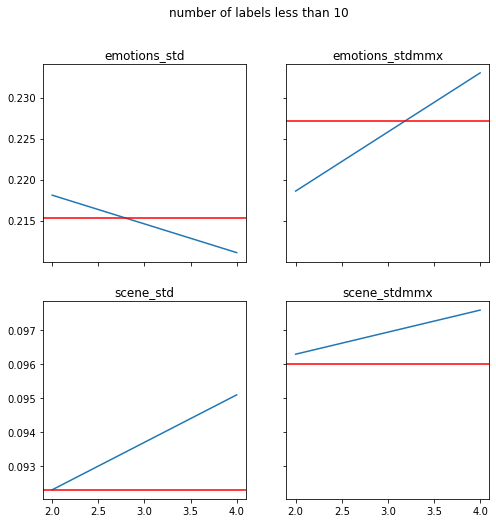

In [21]:
x = [2, 4]
y_emotions_std = [0.2181, 0.2111]
y_scene_std = [0.0923, 0.0951]
y_emotions_stdmmx = [0.2186, 0.2330]
y_scene_stdmmx = [0.0963, 0.0976]
y_emotions = [y_emotions_std, y_emotions_stdmmx]
y_scene = [y_scene_std, y_scene_stdmmx]
y_values = [y_emotions, y_scene]
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey='row')
for i in range(2):
    for j in range(2):
        axs[i, j].plot(x, y_values[i][j])

fig.suptitle('number of labels less than 10')

axs[0,0].axhline(y=0.2153, color='r', linestyle='-')
axs[0,1].axhline(y=0.2271, color='r', linestyle='-')
axs[1,0].axhline(y=0.0923, color='r', linestyle='-')
axs[1,1].axhline(y=0.0960, color='r', linestyle='-')

axs[0,0].set_title("emotions_std")
axs[0,1].set_title("emotions_stdmmx")
axs[1,0].set_title("scene_std")
axs[1,1].set_title("scene_stdmmx")


Text(0.5, 1.0, 'genbase_stdmmx')

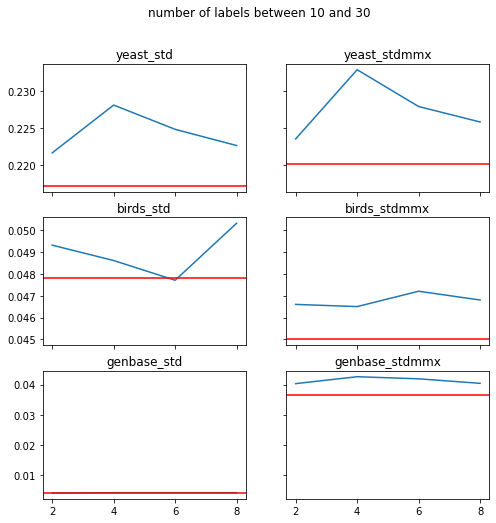

In [22]:
x = [2, 4, 6, 8]
y_yeast_std = [0.2216, 0.2281, 0.2248, 0.2226]
y_birds_std = [0.0493, 0.0486, 0.0477, 0.0503]
y_genbase_std = [0.0040, 0.0041, 0.0041, 0.0041]
y_yeast_stdmmx = [0.2235, 0.2329, 0.2279, 0.2258]
y_birds_stdmmx = [0.0466, 0.0465, 0.0472, 0.0468]
y_genbase_stdmmx = [0.0403, 0.0426, 0.0419, 0.0404]

y_yeast = [y_yeast_std, y_yeast_stdmmx]
y_birds = [y_birds_std, y_birds_stdmmx]
y_genbase = [y_genbase_std, y_genbase_stdmmx]
y_values = [y_yeast, y_birds, y_genbase]

fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey='row')
for i in range(3):
    for j in range(2):
        axs[i, j].plot(x, y_values[i][j])

fig.suptitle('number of labels between 10 and 30')

axs[0,0].axhline(y=0.2171, color='r', linestyle='-')
axs[0,1].axhline(y=0.2201, color='r', linestyle='-')
axs[1,0].axhline(y=0.0478, color='r', linestyle='-')
axs[1,1].axhline(y=0.0450, color='r', linestyle='-')
axs[2,0].axhline(y=0.0039, color='r', linestyle='-')
axs[2,1].axhline(y=0.0366, color='r', linestyle='-')

axs[0, 0].set_title("yeast_std")
axs[1, 0].set_title("birds_std")
axs[2, 0].set_title("genbase_std")
axs[0, 1].set_title("yeast_stdmmx")
axs[1, 1].set_title("birds_stdmmx")
axs[2, 1].set_title("genbase_stdmmx")

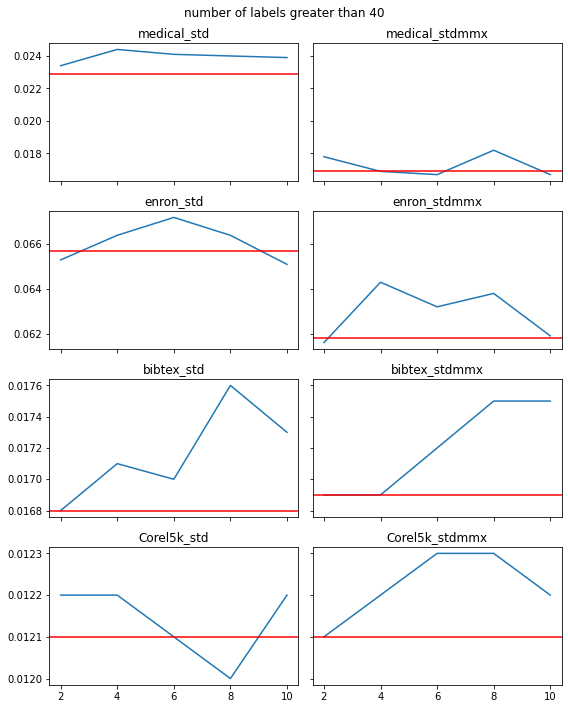

In [25]:
x = [2, 4, 6, 8, 10]
y_medical_std = [0.0234, 0.0244, 0.0241, 0.0240, 0.0239]
y_enron_std = [0.0653, 0.0664, 0.0672, 0.0664, 0.0651]
y_bibtex_std = [0.0168, 0.0171, 0.0170, 0.0176, 0.0173]
y_Corel5k_std = [0.0122, 0.0122, 0.0121, 0.0120, 0.0122]
y_medical_stdmmx = [0.0178, 0.0169, 0.0167, 0.0182, 0.0167]
y_enron_stdmmx = [0.0616, 0.0643, 0.0632, 0.0638, 0.0619]
y_bibtex_stdmmx = [0.0169, 0.0169, 0.0172, 0.0175, 0.0175]
y_Corel5k_stdmmx = [0.0121, 0.0122, 0.0123, 0.0123, 0.0122]
y_medical = [y_medical_std, y_medical_stdmmx]
y_enron = [y_enron_std, y_enron_stdmmx]
y_bibtex = [y_bibtex_std, y_bibtex_stdmmx]
y_Corel5k = [y_Corel5k_std, y_Corel5k_stdmmx]
y_values = [y_medical, y_enron, y_bibtex, y_Corel5k]


fig, axs = plt.subplots(4, 2, figsize=(8, 10), sharex=True, sharey='row')
for i in range(4):
    for j in range(2):
        axs[i, j].plot(x, y_values[i][j])

axs[0, 0].set_title("medical_std")
axs[1, 0].set_title("enron_std")
axs[2, 0].set_title("bibtex_std")
axs[3, 0].set_title("Corel5k_std")
axs[0, 1].set_title("medical_stdmmx")
axs[1, 1].set_title("enron_stdmmx")
axs[2, 1].set_title("bibtex_stdmmx")
axs[3, 1].set_title("Corel5k_stdmmx")

axs[0,0].axhline(y=0.0229, color='r', linestyle='-')
axs[1,0].axhline(y=0.0657, color='r', linestyle='-')
axs[2,0].axhline(y=0.0168, color='r', linestyle='-')
axs[3,0].axhline(y=0.0121, color='r', linestyle='-')
axs[0,1].axhline(y=0.0169, color='r', linestyle='-')
axs[1,1].axhline(y=0.0618, color='r', linestyle='-')
axs[2,1].axhline(y=0.0169, color='r', linestyle='-')
axs[3,1].axhline(y=0.0121, color='r', linestyle='-')

fig.suptitle('number of labels greater than 40')
fig.tight_layout()

Standard classification with full features vs Super classification with full features, with other metrics, f1_score micro, macro and weighted

In [91]:
from sklearn.metrics import f1_score
f1_score_total = []
for datasets, no_clses in zip(datasets_list, no_clses_list):
    for i in range(len(datasets)):
        X, y, feature_names, label_names = load_dataset(datasets[i], 'undivided')
        X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
        y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        standard_f1_micros = []
        standard_f1_macros = []
        standard_f1_weighteds = []
        super_f1_micros = []
        super_f1_macros = []
        super_f1_weighteds = []
        to_print = ''
        fold_count = 0

        for train_idx, test_idx in k_fold.split(X, y):
            
            fold_count += 1
            print('Split ============================================================================', fold_count)
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # get super classification acc(f1_micro, f1_macro, f1_weighted)
            dict_cls_f1mic = dict()   # no_cls:super_ham dictionary
            dict_cls_f1mac = dict()
            dict_cls_f1wei = dict()
            
            for no_cls in no_clses:   
                print('no_cls is ', no_cls)
                X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
                y_test_pred_super, y_test_super = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
                from sklearn.metrics import f1_score
                super_f1mic = f1_score(y_test_super, y_test_pred_super, average='micro') 
                super_f1mac = f1_score(y_test_super, y_test_pred_super, average='macro')
                super_f1wei = f1_score(y_test_super, y_test_pred_super, average='weighted')
                
                dict_cls_f1mic[no_cls] = super_f1mic
                dict_cls_f1mac[no_cls] = super_f1mac
                dict_cls_f1wei[no_cls] = super_f1wei
                
                print('super_f1mic: ', super_f1mic)
                print('dict_cls_f1mic: ', dict_cls_f1mic)
                print('super_f1mac: ', super_f1mac)
                print('dict_cls_f1mac: ', dict_cls_f1mac)
                print('super_f1wei: ', super_f1wei)
                print('dict_cls_f1wei: ', dict_cls_f1wei)
                
            super_f1_micros.append(dict_cls_f1mic)
            super_f1_macros.append(dict_cls_f1mac)
            super_f1_weighteds.append(dict_cls_f1wei)
            
            print('super_f1_micros: ', super_f1_micros)
            print('super_f1_macros: ', super_f1_macros)
            print('super_f1_weighteds', super_f1_weighteds)
            print("-------------------------------------------------------------")


            # get standard classficaition acc(hl)
            scaler_1 = StandardScaler()
            scaler_2 = MinMaxScaler()
            X_train_scaled_1 = scaler_1.fit_transform(X_train)
            X_test_scaled_1 = scaler_1.fit_transform(X_test)
            X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
            X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)

            clf = MLkNN(k=3)
            clf.fit(X_train_scaled_2, y_train)
            y_test_pred = clf.predict(X_test_scaled_2)
            
            standard_f1mic = f1_score(y_test, y_test_pred, average='micro')
            standard_f1mac = f1_score(y_test, y_test_pred, average='macro')
            standard_f1wei = f1_score(y_test, y_test_pred, average='weighted')
            
            print('standard_f1_micro: ', standard_f1mic)
            print('standard_f1_macro: ', standard_f1mac)
            print('standard_f1_weighted: ', standard_f1wei)
            
            standard_f1_micros.append(standard_f1mic)
            standard_f1_macros.append(standard_f1mac)
            standard_f1_weighteds.append(standard_f1wei)

            # to write the results
            to_print += '--------------Fold %d----------------\n' % fold_count
            to_print += 'Standard classification with full feature f1 micro: %.4f\n' % standard_f1mic
            to_print += 'Standard classification with full feature f1 macro: %.4f\n' % standard_f1mac
            to_print += 'Standard classification with full feature f1 weighted: %.4f\n' % standard_f1wei
            if len(no_clses) == 2:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
            elif len(no_clses) == 4:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
                to_print += 'Super classification with full feature f1 micro with 6 clusters: %.4f\n' % dict_cls_f1mic[6]
                to_print += 'Super classification with full feature f1 macro with 6 clusters: %.4f\n' % dict_cls_f1mac[6]
                to_print += 'Super classification with full feature f1 weighted with 6 clusters: %.4f\n' % dict_cls_f1wei[6]
                to_print += 'Super classification with full feature f1 micro with 8 clusters: %.4f\n' % dict_cls_f1mic[8]
                to_print += 'Super classification with full feature f1 macro with 8 clusters: %.4f\n' % dict_cls_f1mac[8]
                to_print += 'Super classification with full feature f1 weighted with 8 clusters: %.4f\n' % dict_cls_f1wei[8]
            else:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
                to_print += 'Super classification with full feature f1 micro with 6 clusters: %.4f\n' % dict_cls_f1mic[6]
                to_print += 'Super classification with full feature f1 macro with 6 clusters: %.4f\n' % dict_cls_f1mac[6]
                to_print += 'Super classification with full feature f1 weighted with 6 clusters: %.4f\n' % dict_cls_f1wei[6]
                to_print += 'Super classification with full feature f1 micro with 8 clusters: %.4f\n' % dict_cls_f1mic[8]
                to_print += 'Super classification with full feature f1 macro with 8 clusters: %.4f\n' % dict_cls_f1mac[8]
                to_print += 'Super classification with full feature f1 weighted with 8 clusters: %.4f\n' % dict_cls_f1wei[8]
                to_print += 'Super classification with full feature f1 micro with 10 clusters: %.4f\n' % dict_cls_f1mic[10]
                to_print += 'Super classification with full feature f1 macro with 10 clusters: %.4f\n' % dict_cls_f1mac[10]
                to_print += 'Super classification with full feature f1 weighted with 10 clusters: %.4f\n' % dict_cls_f1wei[10]

        to_print += '--------------Average----------------\n'
        
        ave_std_f1mic = np.average(standard_f1_micros)
        ave_std_f1mac = np.average(standard_f1_macros)
        ave_std_f1wei = np.average(standard_f1_weighteds)
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1mic
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1mac
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1wei

        f1_weighted.append(ave_std_f1wei)
        
        if len(no_clses) == 2:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
        
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei]
            
            
        elif len(no_clses) == 4:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
            
            ave_6_f1mic = np.average([super_f1_micros[0][6], super_f1_micros[1][6], super_f1_micros[2][6], super_f1_micros[3][6], super_f1_micros[4][6]])
            ave_6_f1mac = np.average([super_f1_macros[0][6], super_f1_macros[1][6], super_f1_macros[2][6], super_f1_macros[3][6], super_f1_macros[4][6]])
            ave_6_f1wei = np.average([super_f1_weighteds[0][6], super_f1_weighteds[1][6], super_f1_weighteds[2][6], super_f1_weighteds[3][6], super_f1_weighteds[4][6]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mic
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mac
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1wei
            
            ave_8_f1mic = np.average([super_f1_micros[0][8], super_f1_micros[1][8], super_f1_micros[2][8], super_f1_micros[3][8], super_f1_micros[4][8]])
            ave_8_f1mac = np.average([super_f1_macros[0][8], super_f1_macros[1][8], super_f1_macros[2][8], super_f1_macros[3][8], super_f1_macros[4][8]])
            ave_8_f1wei = np.average([super_f1_weighteds[0][8], super_f1_weighteds[1][8], super_f1_weighteds[2][8], super_f1_weighteds[3][8], super_f1_weighteds[4][8]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mic
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mac
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1wei
            
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic, ave_6_f1mic, ave_8_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac, ave_6_f1mac, ave_8_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei, ave_6_f1wei, ave_8_f1wei]
            
            
        else:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
            
            ave_6_f1mic = np.average([super_f1_micros[0][6], super_f1_micros[1][6], super_f1_micros[2][6], super_f1_micros[3][6], super_f1_micros[4][6]])
            ave_6_f1mac = np.average([super_f1_macros[0][6], super_f1_macros[1][6], super_f1_macros[2][6], super_f1_macros[3][6], super_f1_macros[4][6]])
            ave_6_f1wei = np.average([super_f1_weighteds[0][6], super_f1_weighteds[1][6], super_f1_weighteds[2][6], super_f1_weighteds[3][6], super_f1_weighteds[4][6]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mic
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mac
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1wei
            
            ave_8_f1mic = np.average([super_f1_micros[0][8], super_f1_micros[1][8], super_f1_micros[2][8], super_f1_micros[3][8], super_f1_micros[4][8]])
            ave_8_f1mac = np.average([super_f1_macros[0][8], super_f1_macros[1][8], super_f1_macros[2][8], super_f1_macros[3][8], super_f1_macros[4][8]])
            ave_8_f1wei = np.average([super_f1_weighteds[0][8], super_f1_weighteds[1][8], super_f1_weighteds[2][8], super_f1_weighteds[3][8], super_f1_weighteds[4][8]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mic
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mac
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1wei

            ave_10_f1mic = np.average([super_f1_micros[0][10], super_f1_micros[1][10], super_f1_micros[2][10], super_f1_micros[3][10], super_f1_micros[4][10]])
            ave_10_f1mac = np.average([super_f1_macros[0][10], super_f1_macros[1][10], super_f1_macros[2][10], super_f1_macros[3][10], super_f1_macros[4][10]])
            ave_10_f1wei = np.average([super_f1_weighteds[0][10], super_f1_weighteds[1][10], super_f1_weighteds[2][10], super_f1_weighteds[3][10], super_f1_weighteds[4][10]])
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1mic
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1mac
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1wei
            
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic, ave_6_f1mic, ave_8_f1mic, ave_10_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac, ave_6_f1mac, ave_8_f1mac, ave_10_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei, ave_6_f1wei, ave_8_f1wei, ave_10_f1wei]
            
        f1_score = [f1_micro, f1_macro, f1_weighted]
        dict_f1 = dict()
        dict_f1[datasets[i]] = f1_score   # dictionary datasetname : [f1_mic, f1_mac, f1_wei]
        f1_score_total.append(dict_f1)
        
        f = open('records/f1_score/record_f1_mic_mac_wei' + datasets[i] + '_full_standard_super_clf.txt', 'w')
        f.write(to_print)
        f.close()

emotions:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_f1mic:  0.672686230248307
dict_cls_f1mic:  {2: 0.672686230248307}
super_f1mac:  0.6664690093100303
dict_cls_f1mac:  {2: 0.6664690093100303}
super_f1wei:  0.6741891436787861
dict_cls_f1wei:  {2: 0.6741891436787861}
no_cls is  4
super_f1mic:  0.6541176470588236
dict_cls_f1mic:  {2: 0.672686230248307, 4: 0.6541176470588236}
super_f1mac:  0.6456300967539972
dict_cls_f1mac:  {2: 0.6664690093100303, 4: 0.6456300967539972}
super_f1wei:  0.6541340508885353
dict_cls_f1wei:  {2: 0.6741891436787861, 4: 0.6541340508885353}
super_f1_micros:  [{2: 0.672686230248307, 4: 0.6541176470588236}]
super_f1_macros:  [{2: 0.6664690093100303, 4: 0.6456300967539972}]
super_f1_weighteds [{2: 0.6741891436787861, 4: 0.6541340508885353}]
-------------------------------------------------------------
standard_f1_micro:  0.660332541567696
standard_f1_macro:  0.652681483

standard_f1_micro:  0.7477386934673368
standard_f1_macro:  0.7546067946709255
standard_f1_weighted:  0.7431388736251491
Split ============================================================================ 3
no_cls is  2
super_f1mic:  0.7003891050583657
dict_cls_f1mic:  {2: 0.7003891050583657}
super_f1mac:  0.7120991576395689
dict_cls_f1mac:  {2: 0.7120991576395689}
super_f1wei:  0.6979730646698652
dict_cls_f1wei:  {2: 0.6979730646698652}
no_cls is  4
super_f1mic:  0.7100000000000001
dict_cls_f1mic:  {2: 0.7003891050583657, 4: 0.7100000000000001}
super_f1mac:  0.719520313823586
dict_cls_f1mac:  {2: 0.7120991576395689, 4: 0.719520313823586}
super_f1wei:  0.7061235825565763
dict_cls_f1wei:  {2: 0.6979730646698652, 4: 0.7061235825565763}
super_f1_micros:  [{2: 0.7360970677451971, 4: 0.7183098591549296}, {2: 0.736734693877551, 4: 0.7474747474747475}, {2: 0.7003891050583657, 4: 0.7100000000000001}]
super_f1_macros:  [{2: 0.7467661682779121, 4: 0.7282325952207365}, {2: 0.7446343181082348, 4: 0.

standard_f1_micro:  0.6243705941591139
standard_f1_macro:  0.4306138161495485
standard_f1_weighted:  0.5992958863900822
Split ============================================================================ 3
no_cls is  2
super_f1mic:  0.6355828220858896
dict_cls_f1mic:  {2: 0.6355828220858896}
super_f1mac:  0.4458340208434941
dict_cls_f1mac:  {2: 0.4458340208434941}
super_f1wei:  0.6152367957991869
dict_cls_f1wei:  {2: 0.6152367957991869}
no_cls is  4
super_f1mic:  0.6299060919817
dict_cls_f1mic:  {2: 0.6355828220858896, 4: 0.6299060919817}
super_f1mac:  0.4586136523244383
dict_cls_f1mac:  {2: 0.4458340208434941, 4: 0.4586136523244383}
super_f1wei:  0.6190358585855914
dict_cls_f1wei:  {2: 0.6152367957991869, 4: 0.6190358585855914}
no_cls is  6
super_f1mic:  0.6241064826226276
dict_cls_f1mic:  {2: 0.6355828220858896, 4: 0.6299060919817, 6: 0.6241064826226276}
super_f1mac:  0.44504059881783
dict_cls_f1mac:  {2: 0.4458340208434941, 4: 0.4586136523244383, 6: 0.44504059881783}
super_f1wei:  0.

standard_f1_micro:  0.6463130659767141
standard_f1_macro:  0.45466951893984947
standard_f1_weighted:  0.6280544992821298
birds:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_f1mic:  0.42533936651583715
dict_cls_f1mic:  {2: 0.42533936651583715}
super_f1mac:  0.3088141245608952
dict_cls_f1mac:  {2: 0.3088141245608952}
super_f1wei:  0.4147011634345762
dict_cls_f1wei:  {2: 0.4147011634345762}
no_cls is  4
super_f1mic:  0.46636771300448426
dict_cls_f1mic:  {2: 0.42533936651583715, 4: 0.46636771300448426}
super_f1mac:  0.3274957095737495
dict_cls_f1mac:  {2: 0.3088141245608952, 4: 0.3274957095737495}
super_f1wei:  0.44251089424161283
dict_cls_f1wei:  {2: 0.4147011634345762, 4: 0.44251089424161283}
no_cls is  6
super_f1mic:  0.4392523364485982
dict_cls_f1mic:  {2: 0.42533936651583715, 4: 0.46636771300448426, 6: 0.4392523364485982}
super_f1mac:  0.30485599933016116
dict_cls_f1mac:  {2: 0.308814124560

standard_f1_micro:  0.5592417061611374
standard_f1_macro:  0.482360312546071
standard_f1_weighted:  0.5519968925070028
Split ============================================================================ 5
no_cls is  2
super_f1mic:  0.47619047619047616
dict_cls_f1mic:  {2: 0.47619047619047616}
super_f1mac:  0.3431497242469077
dict_cls_f1mac:  {2: 0.3431497242469077}
super_f1wei:  0.45629584761481934
dict_cls_f1wei:  {2: 0.45629584761481934}
no_cls is  4
super_f1mic:  0.4796747967479675
dict_cls_f1mic:  {2: 0.47619047619047616, 4: 0.4796747967479675}
super_f1mac:  0.3698921030456658
dict_cls_f1mac:  {2: 0.3431497242469077, 4: 0.3698921030456658}
super_f1wei:  0.46069238416433894
dict_cls_f1wei:  {2: 0.45629584761481934, 4: 0.46069238416433894}
no_cls is  6
super_f1mic:  0.48582995951417
dict_cls_f1mic:  {2: 0.47619047619047616, 4: 0.4796747967479675, 6: 0.48582995951417}
super_f1mac:  0.3838773266284126
dict_cls_f1mac:  {2: 0.3431497242469077, 4: 0.3698921030456658, 6: 0.3838773266284126}

super_f1mic:  0.43205574912891986
dict_cls_f1mic:  {2: 0.48184818481848185, 4: 0.3597560975609756, 6: 0.4420289855072464, 8: 0.43205574912891986}
super_f1mac:  0.41165068040226954
dict_cls_f1mac:  {2: 0.43914787456613036, 4: 0.3506600395489284, 6: 0.40948477180361237, 8: 0.41165068040226954}
super_f1wei:  0.40846649732276435
dict_cls_f1wei:  {2: 0.4979080829907651, 4: 0.3907194133609228, 6: 0.40478853932504466, 8: 0.40846649732276435}
super_f1_micros:  [{2: 0.611111111111111, 4: 0.6026490066225165, 6: 0.6163934426229508, 8: 0.5923566878980893}, {2: 0.5211726384364821, 4: 0.546583850931677, 6: 0.5176470588235295, 8: 0.5}, {2: 0.48184818481848185, 4: 0.3597560975609756, 6: 0.4420289855072464, 8: 0.43205574912891986}]
super_f1_macros:  [{2: 0.4973416501194279, 4: 0.5037125486471892, 6: 0.5353681358583319, 8: 0.532644824311491}, {2: 0.5035664919875446, 4: 0.504619123566492, 6: 0.5009154198627883, 8: 0.5009154198627883}, {2: 0.43914787456613036, 4: 0.3506600395489284, 6: 0.40948477180361237

super_f1mic:  0.7078891257995736
dict_cls_f1mic:  {2: 0.6940451745379878, 4: 0.6919642857142857, 6: 0.7041036717062634, 8: 0.7078891257995736}
super_f1mac:  0.268373081091631
dict_cls_f1mac:  {2: 0.2771208749004984, 4: 0.2787894417449033, 6: 0.2967465224650724, 8: 0.268373081091631}
super_f1wei:  0.6539174143441095
dict_cls_f1wei:  {2: 0.6495180692624587, 4: 0.6410242110142731, 6: 0.6601826728950824, 8: 0.6539174143441095}
no_cls is  10
super_f1mic:  0.6993603411513859
dict_cls_f1mic:  {2: 0.6940451745379878, 4: 0.6919642857142857, 6: 0.7041036717062634, 8: 0.7078891257995736, 10: 0.6993603411513859}
super_f1mac:  0.24759164031019018
dict_cls_f1mac:  {2: 0.2771208749004984, 4: 0.2787894417449033, 6: 0.2967465224650724, 8: 0.268373081091631, 10: 0.24759164031019018}
super_f1wei:  0.6486800666577823
dict_cls_f1wei:  {2: 0.6495180692624587, 4: 0.6410242110142731, 6: 0.6601826728950824, 8: 0.6539174143441095, 10: 0.6486800666577823}
super_f1_micros:  [{2: 0.6940451745379878, 4: 0.691964285

super_f1mic:  0.6782608695652174
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174}
super_f1mac:  0.23669885041374006
dict_cls_f1mac:  {2: 0.231198217591432, 4: 0.23204241564977848, 6: 0.23669885041374006}
super_f1wei:  0.6456284474254069
dict_cls_f1wei:  {2: 0.6323074931625152, 4: 0.6390111816285314, 6: 0.6456284474254069}
no_cls is  8
super_f1mic:  0.6652542372881356
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174, 8: 0.6652542372881356}
super_f1mac:  0.2560121440397606
dict_cls_f1mac:  {2: 0.231198217591432, 4: 0.23204241564977848, 6: 0.23669885041374006, 8: 0.2560121440397606}
super_f1wei:  0.6461652265434872
dict_cls_f1wei:  {2: 0.6323074931625152, 4: 0.6390111816285314, 6: 0.6456284474254069, 8: 0.6461652265434872}
no_cls is  10
super_f1mic:  0.68
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174, 8: 0.6652542372881356, 10: 0.68}
super_f1mac:  0.24975250527238183
dict_cls

super_f1mic:  0.47331128956069907
dict_cls_f1mic:  {2: 0.4771084337349397, 4: 0.489415749364945, 6: 0.4767547857793984, 8: 0.47234416154521514, 10: 0.47331128956069907}
super_f1mac:  0.14084531362275574
dict_cls_f1mac:  {2: 0.1356264107899542, 4: 0.14708722795796292, 6: 0.1446247638390625, 8: 0.14417971476457175, 10: 0.14084531362275574}
super_f1wei:  0.4397588321336519
dict_cls_f1wei:  {2: 0.43968025039961367, 4: 0.4612135621792484, 6: 0.4491439032793677, 8: 0.45241844324836267, 10: 0.4397588321336519}
super_f1_micros:  [{2: 0.4771084337349397, 4: 0.489415749364945, 6: 0.4767547857793984, 8: 0.47234416154521514, 10: 0.47331128956069907}]
super_f1_macros:  [{2: 0.1356264107899542, 4: 0.14708722795796292, 6: 0.1446247638390625, 8: 0.14417971476457175, 10: 0.14084531362275574}]
super_f1_weighteds [{2: 0.43968025039961367, 4: 0.4612135621792484, 6: 0.4491439032793677, 8: 0.45241844324836267, 10: 0.4397588321336519}]
-------------------------------------------------------------
standard_f1

super_f1mic:  0.48559670781893005
dict_cls_f1mic:  {2: 0.460717749757517, 4: 0.471559633027523, 6: 0.47505720823798625, 8: 0.48559670781893005}
super_f1mac:  0.19824593259918852
dict_cls_f1mac:  {2: 0.18710464024499376, 4: 0.1877229548495025, 6: 0.18608273558625607, 8: 0.19824593259918852}
super_f1wei:  0.4583945589278449
dict_cls_f1wei:  {2: 0.4383144432418722, 4: 0.44313713280045397, 6: 0.45211128156261565, 8: 0.4583945589278449}
no_cls is  10
super_f1mic:  0.488232579603138
dict_cls_f1mic:  {2: 0.460717749757517, 4: 0.471559633027523, 6: 0.47505720823798625, 8: 0.48559670781893005, 10: 0.488232579603138}
super_f1mac:  0.19074541482423135
dict_cls_f1mac:  {2: 0.18710464024499376, 4: 0.1877229548495025, 6: 0.18608273558625607, 8: 0.19824593259918852, 10: 0.19074541482423135}
super_f1wei:  0.4578638691253909
dict_cls_f1wei:  {2: 0.4383144432418722, 4: 0.44313713280045397, 6: 0.45211128156261565, 8: 0.4583945589278449, 10: 0.4578638691253909}
super_f1_micros:  [{2: 0.4771084337349397, 4

super_f1mic:  0.2671962448095324
dict_cls_f1mic:  {2: 0.2744119743406985, 4: 0.27476835352815393, 6: 0.271497919556172, 8: 0.2755031228313671, 10: 0.2671962448095324}
super_f1mac:  0.15149134806703118
dict_cls_f1mac:  {2: 0.16384299388871296, 4: 0.16495087355195864, 6: 0.17005166241630904, 8: 0.16818249880057667, 10: 0.15149134806703118}
super_f1wei:  0.2355339125658829
dict_cls_f1wei:  {2: 0.24235522592342715, 4: 0.24285955183178912, 6: 0.2476777516103582, 8: 0.24764248058215507, 10: 0.2355339125658829}
super_f1_micros:  [{2: 0.2744119743406985, 4: 0.27476835352815393, 6: 0.271497919556172, 8: 0.2755031228313671, 10: 0.2671962448095324}]
super_f1_macros:  [{2: 0.16384299388871296, 4: 0.16495087355195864, 6: 0.17005166241630904, 8: 0.16818249880057667, 10: 0.15149134806703118}]
super_f1_weighteds [{2: 0.24235522592342715, 4: 0.24285955183178912, 6: 0.2476777516103582, 8: 0.24764248058215507, 10: 0.2355339125658829}]
-------------------------------------------------------------
standard

super_f1mic:  0.26513680494263014
dict_cls_f1mic:  {2: 0.2711925939371937, 4: 0.26693667157584683, 6: 0.27154706094482506, 8: 0.26513680494263014}
super_f1mac:  0.15542228051362603
dict_cls_f1mac:  {2: 0.15208019397597183, 4: 0.14820510342565021, 6: 0.1533018488606469, 8: 0.15542228051362603}
super_f1wei:  0.23450925948656406
dict_cls_f1wei:  {2: 0.2323478607042484, 4: 0.22709947541170214, 6: 0.23372443378547977, 8: 0.23450925948656406}
no_cls is  10
super_f1mic:  0.26273744008521216
dict_cls_f1mic:  {2: 0.2711925939371937, 4: 0.26693667157584683, 6: 0.27154706094482506, 8: 0.26513680494263014, 10: 0.26273744008521216}
super_f1mac:  0.1528020719132877
dict_cls_f1mac:  {2: 0.15208019397597183, 4: 0.14820510342565021, 6: 0.1533018488606469, 8: 0.15542228051362603, 10: 0.1528020719132877}
super_f1wei:  0.23103235176900108
dict_cls_f1wei:  {2: 0.2323478607042484, 4: 0.22709947541170214, 6: 0.23372443378547977, 8: 0.23450925948656406, 10: 0.23103235176900108}
super_f1_micros:  [{2: 0.274411

super_f1mic:  0.13917238819818148
dict_cls_f1mic:  {2: 0.12164788184998057, 4: 0.12099097368926442, 6: 0.13053263315828958, 8: 0.14001823154056517, 10: 0.13917238819818148}
super_f1mac:  0.024253328358290777
dict_cls_f1mac:  {2: 0.024884574357885866, 4: 0.024539753522861325, 6: 0.024968811584227164, 8: 0.024829720554556255, 10: 0.024253328358290777}
super_f1wei:  0.1151062550106777
dict_cls_f1wei:  {2: 0.1031334238924521, 4: 0.1032011417550864, 6: 0.11116234296884121, 8: 0.11698611542126812, 10: 0.1151062550106777}
super_f1_micros:  [{2: 0.12164788184998057, 4: 0.12099097368926442, 6: 0.13053263315828958, 8: 0.14001823154056517, 10: 0.13917238819818148}]
super_f1_macros:  [{2: 0.024884574357885866, 4: 0.024539753522861325, 6: 0.024968811584227164, 8: 0.024829720554556255, 10: 0.024253328358290777}]
super_f1_weighteds [{2: 0.1031334238924521, 4: 0.1032011417550864, 6: 0.11116234296884121, 8: 0.11698611542126812, 10: 0.1151062550106777}]
--------------------------------------------------

super_f1mic:  0.13130128956623682
dict_cls_f1mic:  {2: 0.1274184092241548, 4: 0.12619047619047621, 6: 0.1311539209963028, 8: 0.13130128956623682}
super_f1mac:  0.02903521553325628
dict_cls_f1mac:  {2: 0.02914954404824269, 4: 0.029284351345292985, 6: 0.028719450450588713, 8: 0.02903521553325628}
super_f1wei:  0.11238282297407871
dict_cls_f1wei:  {2: 0.10817840926999131, 4: 0.1095723955799336, 6: 0.11185325121647914, 8: 0.11238282297407871}
no_cls is  10
super_f1mic:  0.13034943070278762
dict_cls_f1mic:  {2: 0.1274184092241548, 4: 0.12619047619047621, 6: 0.1311539209963028, 8: 0.13130128956623682, 10: 0.13034943070278762}
super_f1mac:  0.028544606009924017
dict_cls_f1mac:  {2: 0.02914954404824269, 4: 0.029284351345292985, 6: 0.028719450450588713, 8: 0.02903521553325628, 10: 0.028544606009924017}
super_f1wei:  0.1107651308583225
dict_cls_f1wei:  {2: 0.10817840926999131, 4: 0.1095723955799336, 6: 0.11185325121647914, 8: 0.11238282297407871, 10: 0.1107651308583225}
super_f1_micros:  [{2: 0.

In [128]:
dataset_names = ['emotions', 'scene',  'yeast', 'birds', 'genbase', 'medical', 'enron', 'bibtex', 'Corel5k']

In [178]:
del f1_score_total[2]['yeast'][2][-1]
del f1_score_total[3]['birds'][2][-1]
del f1_score_total[4]['genbase'][2][-1]
del f1_score_total[5]['medical'][2][-1]
del f1_score_total[6]['enron'][2][-1]
del f1_score_total[7]['bibtex'][2][-1]

In [205]:
emotions_f1_mic = [0.6193, 0.635, 0.6205]
emotions_f1_mac = [0.6042, 0.6247404499120723, 0.6040537265840673]
emotions_f1_wei = [0.6152, 0.6333, 0.6163]

scene_f1_mic = [0.7243, 0.7255386436634708, 0.7203478132964884]
scene_f1_mac =  [0.7326, 0.7351476071429619, 0.7277765263689744]
scene_f1_wei =  [0.7213, 0.7244260771014777, 0.7170940541116632]

yeast_f1_mic = [0.6213, 0.6315844403728665, 0.6227485601694784, 0.6216801043689464, 0.6185563096396196]
yeast_f1_mac = [0.4298, 0.4393538011358384, 0.44915472199014034, 0.4392109720660772, 0.4363484430926601]
yeast_f1_wei = [0.5992, 0.6106371807940848, 0.6116664732697432, 0.6056119041321917, 0.6020120419069921]

birds_f1_mic = [0.4904, 0.46861187194018933, 0.48142557635813155, 0.47420542366213675, 0.4698923649474616]
birds_f1_mac = [0.3837, 0.3465444025031573, 0.346549905054104, 0.334764347899474, 0.3394271860118804]
birds_f1_wei = [0.4745, 0.4448504498682701, 0.4583012266525632, 0.4548866317170718, 0.4507584434489556]

genbase_f1_mic = [0.5448, 0.5229135856136776, 0.5059705227066826, 0.48280208746562503, 0.49648425057114604]
genbase_f1_mac = [0.4851, 0.4850729731983227, 0.46818671154282343, 0.4483164208029676, 0.44993333527505913]
genbase_f1_wei = [0.5078, 0.5078311480479373, 0.49387068429162984, 0.4641938969904542, 0.47046184697147175]

medical_f1_mic = [0.6822, 0.6685134158679638, 0.6724853164077301, 0.6787235044721338, 0.6695466544462928, 0.6768620079319758]
medical_f1_mac = [0.2634, 0.258846333262784, 0.25331994301465494, 0.2577287267913292, 0.26342948018446594, 0.2486924804066172]
medical_f1_wei = [0.6507, 0.6391635069713436, 0.633496691962724, 0.6406048234182397, 0.6487772362077993, 0.6364778132526154]

enron_f1_mic = [0.4697, 0.45969735164189124, 0.460101389974885, 0.46753231998277256, 0.46492954188701896, 0.4696702847269547]
enron_f1_mac = [0.1713, 0.16965584346555834, 0.17650474068945027, 0.1767231626388414, 0.17533149083489866, 0.17129094183617014]
enron_f1_wei = [0.4422, 0.43599238135221635, 0.4399937043304087, 0.4451788285000425, 0.4454878131233085, 0.44317651884987985]

bibtex_f1_mic = [0.2755, 0.2751578335776725, 0.27310826947302086, 0.2722541747660671, 0.2730892824173964, 0.2674188251991464]
bibtex_f1_mac = [0.1590, 0.15836370880096864, 0.15799371137360632, 0.15971094820152593, 0.16244316891156133, 0.15465317405796436]
bibtex_f1_wei = [0.2371, 0.23663275345561927, 0.23559987385230655, 0.23839843563025634, 0.24294392156529798, 0.2356624320354439]

Corel5k_f1_mic = [0.1316, 0.12259889568127598, 0.1284020728351251, 0.1294555861532666, 0.1314200996001449, 0.1319001795298237]
Corel5k_f1_mac = [0.0280, 0.027638613609559097, 0.02810558110567176, 0.02783073007669144, 0.02774474468997406, 0.027870635067696225]
Corel5k_f1_wei = [0.1107, 0.10436351813256928, 0.10889043062638118, 0.10963379990957416, 0.11116543246028902, 0.11102840982270128]

In [206]:
f1_score_total[0]['emotions'][0] = emotions_f1_mic
f1_score_total[0]['emotions'][1] = emotions_f1_mac
f1_score_total[0]['emotions'][2] = emotions_f1_wei

f1_score_total[1]['scene'][0] = scene_f1_mic
f1_score_total[1]['scene'][1] = scene_f1_mac
f1_score_total[1]['scene'][2] = scene_f1_wei

f1_score_total[2]['yeast'][0] = yeast_f1_mic
f1_score_total[2]['yeast'][1] = yeast_f1_mac
f1_score_total[2]['yeast'][2] = yeast_f1_wei

f1_score_total[3]['birds'][0] = birds_f1_mic
f1_score_total[3]['birds'][1] = birds_f1_mac
f1_score_total[3]['birds'][2] = birds_f1_wei

f1_score_total[4]['genbase'][0] = genbase_f1_mic
f1_score_total[4]['genbase'][1] = genbase_f1_mac
f1_score_total[4]['genbase'][2] = genbase_f1_wei

f1_score_total[5]['medical'][0] = medical_f1_mic
f1_score_total[5]['medical'][1] = medical_f1_mac
f1_score_total[5]['medical'][2] = medical_f1_wei

f1_score_total[6]['enron'][0] = enron_f1_mic
f1_score_total[6]['enron'][1] = enron_f1_mac
f1_score_total[6]['enron'][2] = enron_f1_wei

f1_score_total[7]['bibtex'][0] = bibtex_f1_mic
f1_score_total[7]['bibtex'][1] = bibtex_f1_mac
f1_score_total[7]['bibtex'][2] = bibtex_f1_wei

f1_score_total[8]['Corel5k'][0] = Corel5k_f1_mic
f1_score_total[8]['Corel5k'][1] = Corel5k_f1_mac
f1_score_total[8]['Corel5k'][2] = Corel5k_f1_wei

In [207]:
f1_score_total

[{'emotions': [[0.6193, 0.635, 0.6205],
   [0.6042, 0.6247404499120723, 0.6040537265840673],
   [0.6152, 0.6333, 0.6163]]},
 {'scene': [[0.7243, 0.7255386436634708, 0.7203478132964884],
   [0.7326, 0.7351476071429619, 0.7277765263689744],
   [0.7213, 0.7244260771014777, 0.7170940541116632]]},
 {'yeast': [[0.6213,
    0.6315844403728665,
    0.6227485601694784,
    0.6216801043689464,
    0.6185563096396196],
   [0.4298,
    0.4393538011358384,
    0.44915472199014034,
    0.4392109720660772,
    0.4363484430926601],
   [0.5992,
    0.6106371807940848,
    0.6116664732697432,
    0.6056119041321917,
    0.6020120419069921]]},
 {'birds': [[0.4904,
    0.46861187194018933,
    0.48142557635813155,
    0.47420542366213675,
    0.4698923649474616],
   [0.3837,
    0.3465444025031573,
    0.346549905054104,
    0.334764347899474,
    0.3394271860118804],
   [0.4745,
    0.4448504498682701,
    0.4583012266525632,
    0.4548866317170718,
    0.4507584434489556]]},
 {'genbase': [[0.5448,
    0

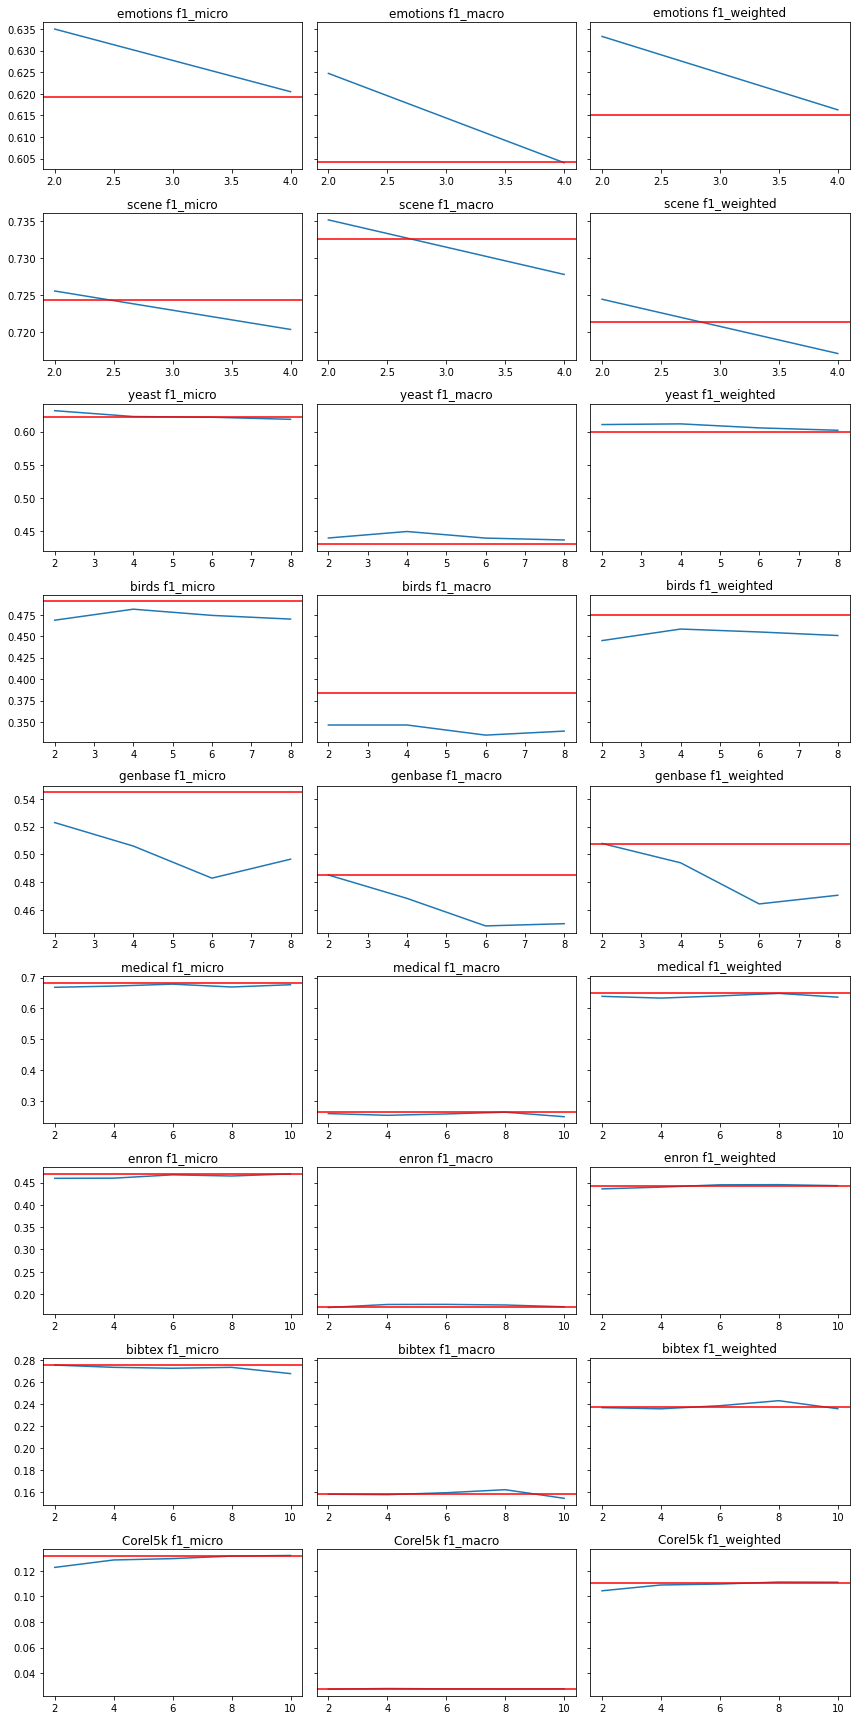

In [208]:
dataset_names = ['emotions', 'scene',  'yeast', 'birds', 'genbase', 'medical', 'enron', 'bibtex', 'Corel5k']
f1 = ['f1_micro', 'f1_macro', 'f1_weighted']
fig, axs = plt.subplots(9, 3, figsize=(12, 24), sharex='row', sharey='row')
for i in range(len(f1_score_total)):
    for j in range(len(f1_score_total[i][dataset_names[i]])):
        
        if len(f1_score_total[i][dataset_names[i]][j]) == 3:  # std, cls2, cls4
            x = [2, 4]
        elif len(f1_score_total[i][dataset_names[i]][j]) == 5:  # std, cls2, cls4, cls6, cls8
            x = [2, 4, 6, 8]
        elif len(f1_score_total[i][dataset_names[i]][j]) == 6:  # std, cls2, cls4, cls6, cls8, cls10
            x = [2, 4, 6, 8, 10]
        
        benchmark_std = f1_score_total[i][dataset_names[i]][j].pop(0)
        y = f1_score_total[i][dataset_names[i]][j]
        axs[i, j].plot(x, y)
        axs[i, j].axhline(y=benchmark_std, color='r', linestyle='-')
        axs[i, j].set_title(dataset_names[i] + ' ' + f1[j])

fig.tight_layout()

Full feature standard classfification acc vs Super classification PSO selected acc, f1 score micro as fitness method.

In [20]:
datasets_small = ['emotions', 'scene']
datasets_medium = ['yeast', 'birds', 'genbase']
datasets_large = ['medical', 'enron', 'bibtex', 'Corel5k']
datasets_list = [datasets_small, datasets_medium, datasets_large]

no_clses_small = 2
no_clses_medium = 4
no_clses_large = 8
no_clses_list = [no_clses_small, no_clses_medium, no_clses_large]

In [23]:
X, y, feature_names, label_names = load_dataset('emotions', 'undivided')

emotions:undivided - exists, not redownloading


In [25]:
len(feature_names)

72

In [27]:
# Main entry
from sklearn.metrics import f1_score

for datasets, no_cls in zip(datasets_list, no_clses_list):
    for i in range(len(datasets)):
        print(datasets[i] + " is running: ===================================================")
        X, y, feature_names, label_names = load_dataset(datasets[i], 'undivided')
        n_features = len(feature_names)
        X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
        y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state = 42)

        full_f1_mics = []
        sel_f1_mics = []
        PSO_durations = []
        f_ratios = []
        to_print = ''
        fold_count = 0

        for train_idx, test_idx in k_fold.split(X, y):
            print('Fold ', fold_count)
            fold_count += 1

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # get full acc
            # get standard classficaition acc(f1)
            scaler_1 = StandardScaler()
            scaler_2 = MinMaxScaler()
            X_train_scaled_1 = scaler_1.fit_transform(X_train)
            X_test_scaled_1 = scaler_1.fit_transform(X_test)
            X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
            X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)

            clf = MLkNN(k=3)
            clf.fit(X_train_scaled_2, y_train)
            y_test_pred = clf.predict(X_test_scaled_2)

            full_f1_mic = f1_score(y_test, y_test_pred, average='micro')
            print('Full_f1_micro: ', full_f1_mic)
            full_f1_mics.append(full_f1_mic)


            #  perform FS
            start_PSO = time.time_ns()    # marking start time of PSO 
        #        problem = FS_ML(minimize=True, X=X_train, y=y_train)
            problem = FS_ML_super(minimize=False, X=X_train, y=y_train, no_cls = no_cls)

            # parameter for PSO
            pop_size = 3
            n_iterations = 5
            swarm = Swarm(n_particles=pop_size, length=n_features, pos_max=1.0, pos_min=0,
                               vel_max=0.2, vel_min=-0.2, problem=problem, n_iterations=n_iterations)    
            best_sol, best_fit = swarm.iterate()
            end_PSO = time.time_ns()      # marking ending time of PSO
            duration_PSO = round((end_PSO - start_PSO)/1000000000, 2)
            PSO_durations.append(duration_PSO)


            # process the final solution
            sel_fea = np.where(best_sol > problem.threshold)[0]
            clf.fit(X_train_scaled_2[:, sel_fea], y_train)
            y_test_pred = clf.predict(X_test_scaled_2[:, sel_fea])
            sel_f1_mic = f1_score(y_test, y_test_pred, average = 'micro')
            print('Selected_f1_micro: ', sel_f1_mic)
            sel_f1_mics.append(sel_f1_mic)
            f_ratios.append(len(sel_fea)/n_features)

            # to write the results
            to_print += '--------------Fold %d----------------\n' % fold_count
            to_print += 'Full feature f1 score micro: %.4f\n' % full_f1_mic
            to_print += 'Fold selected f1 score micro: %.4f\n' % sel_f1_mic
            to_print += 'Time of PSO: %.4f\n' % duration_PSO
            to_print += 'Selection ratio: %.2f\n' % (len(sel_fea)/n_features)
            to_print += 'Selected features: %s\n' % (', '.join([str(ele) for ele in sel_fea]))

        to_print += '--------------Average----------------\n'
        to_print += 'Ave Full Accuracy: %.4f\n' % np.average(full_f1_mics)
        to_print += 'Ave Selection Accuracy: %.4f\n' % np.average(sel_f1_mics)
        to_print += 'Ave time of PSO: %.4f\n' % np.average(PSO_durations)
        to_print += 'Ave Feature Ratio: %.2f\n' % np.average(f_ratios)

        f = open('records/f1_score_PSO/record_' + datasets[i] + 'std_full_superPSO_selected.txt', 'w')
        f.write(to_print)
        f.close()

emotions is running: ===================================================
emotions:undivided - exists, not redownloading
Fold  0
Full_f1_micro:  0.660332541567696
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.6013588659746933
Iterate  2  gbest value is  0.5946345820848162
Iterate  3  gbest value is  0.583672594429282
Iterate  4  gbest value is  0.5831562878426202
Selected_f1_micro:  0.639618138424821
Fold  1
Full_f1_micro:  0.5754716981132075
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.620687990727886
Iterate  2  gbest value is  0.6133601227678358
Iterate  3  gbest value is  0.591150889980773
Iterate  4  gbest value is  0.591150889980773


KeyboardInterrupt: 

In [91]:
from sklearn.metrics import f1_score
f1_score_total = []
for datasets, no_clses in zip(datasets_list, no_clses_list):
    for i in range(len(datasets)):
        X, y, feature_names, label_names = load_dataset(datasets[i], 'undivided')
        X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
        y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        standard_f1_micros = []
        standard_f1_macros = []
        standard_f1_weighteds = []
        super_f1_micros = []
        super_f1_macros = []
        super_f1_weighteds = []
        to_print = ''
        fold_count = 0

        for train_idx, test_idx in k_fold.split(X, y):
            
            fold_count += 1
            print('Split ============================================================================', fold_count)
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # get super classification acc(f1_micro, f1_macro, f1_weighted)
            dict_cls_f1mic = dict()   # no_cls:super_ham dictionary
            dict_cls_f1mac = dict()
            dict_cls_f1wei = dict()
            
            for no_cls in no_clses:   
                print('no_cls is ', no_cls)
                X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
                y_test_pred_super, y_test_super = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
                from sklearn.metrics import f1_score
                super_f1mic = f1_score(y_test_super, y_test_pred_super, average='micro') 
                super_f1mac = f1_score(y_test_super, y_test_pred_super, average='macro')
                super_f1wei = f1_score(y_test_super, y_test_pred_super, average='weighted')
                
                dict_cls_f1mic[no_cls] = super_f1mic
                dict_cls_f1mac[no_cls] = super_f1mac
                dict_cls_f1wei[no_cls] = super_f1wei
                
                print('super_f1mic: ', super_f1mic)
                print('dict_cls_f1mic: ', dict_cls_f1mic)
                print('super_f1mac: ', super_f1mac)
                print('dict_cls_f1mac: ', dict_cls_f1mac)
                print('super_f1wei: ', super_f1wei)
                print('dict_cls_f1wei: ', dict_cls_f1wei)
                
            super_f1_micros.append(dict_cls_f1mic)
            super_f1_macros.append(dict_cls_f1mac)
            super_f1_weighteds.append(dict_cls_f1wei)
            
            print('super_f1_micros: ', super_f1_micros)
            print('super_f1_macros: ', super_f1_macros)
            print('super_f1_weighteds', super_f1_weighteds)
            print("-------------------------------------------------------------")


            # get standard classficaition acc(hl)
            scaler_1 = StandardScaler()
            scaler_2 = MinMaxScaler()
            X_train_scaled_1 = scaler_1.fit_transform(X_train)
            X_test_scaled_1 = scaler_1.fit_transform(X_test)
            X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
            X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)

            clf = MLkNN(k=3)
            clf.fit(X_train_scaled_2, y_train)
            y_test_pred = clf.predict(X_test_scaled_2)
            
            standard_f1mic = f1_score(y_test, y_test_pred, average='micro')
            standard_f1mac = f1_score(y_test, y_test_pred, average='macro')
            standard_f1wei = f1_score(y_test, y_test_pred, average='weighted')
            
            print('standard_f1_micro: ', standard_f1mic)
            print('standard_f1_macro: ', standard_f1mac)
            print('standard_f1_weighted: ', standard_f1wei)
            
            standard_f1_micros.append(standard_f1mic)
            standard_f1_macros.append(standard_f1mac)
            standard_f1_weighteds.append(standard_f1wei)

            # to write the results
            to_print += '--------------Fold %d----------------\n' % fold_count
            to_print += 'Standard classification with full feature f1 micro: %.4f\n' % standard_f1mic
            to_print += 'Standard classification with full feature f1 macro: %.4f\n' % standard_f1mac
            to_print += 'Standard classification with full feature f1 weighted: %.4f\n' % standard_f1wei
            if len(no_clses) == 2:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
            elif len(no_clses) == 4:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
                to_print += 'Super classification with full feature f1 micro with 6 clusters: %.4f\n' % dict_cls_f1mic[6]
                to_print += 'Super classification with full feature f1 macro with 6 clusters: %.4f\n' % dict_cls_f1mac[6]
                to_print += 'Super classification with full feature f1 weighted with 6 clusters: %.4f\n' % dict_cls_f1wei[6]
                to_print += 'Super classification with full feature f1 micro with 8 clusters: %.4f\n' % dict_cls_f1mic[8]
                to_print += 'Super classification with full feature f1 macro with 8 clusters: %.4f\n' % dict_cls_f1mac[8]
                to_print += 'Super classification with full feature f1 weighted with 8 clusters: %.4f\n' % dict_cls_f1wei[8]
            else:
                to_print += 'Super classification with full feature f1 micro with 2 clusters: %.4f\n' % dict_cls_f1mic[2]
                to_print += 'Super classification with full feature f1 macro with 2 clusters: %.4f\n' % dict_cls_f1mac[2]
                to_print += 'Super classification with full feature f1 weighted with 2 clusters: %.4f\n' % dict_cls_f1wei[2]
                to_print += 'Super classification with full feature f1 micro with 4 clusters: %.4f\n' % dict_cls_f1mic[4]
                to_print += 'Super classification with full feature f1 macro with 4 clusters: %.4f\n' % dict_cls_f1mac[4]
                to_print += 'Super classification with full feature f1 weighted with 4 clusters: %.4f\n' % dict_cls_f1wei[4]
                to_print += 'Super classification with full feature f1 micro with 6 clusters: %.4f\n' % dict_cls_f1mic[6]
                to_print += 'Super classification with full feature f1 macro with 6 clusters: %.4f\n' % dict_cls_f1mac[6]
                to_print += 'Super classification with full feature f1 weighted with 6 clusters: %.4f\n' % dict_cls_f1wei[6]
                to_print += 'Super classification with full feature f1 micro with 8 clusters: %.4f\n' % dict_cls_f1mic[8]
                to_print += 'Super classification with full feature f1 macro with 8 clusters: %.4f\n' % dict_cls_f1mac[8]
                to_print += 'Super classification with full feature f1 weighted with 8 clusters: %.4f\n' % dict_cls_f1wei[8]
                to_print += 'Super classification with full feature f1 micro with 10 clusters: %.4f\n' % dict_cls_f1mic[10]
                to_print += 'Super classification with full feature f1 macro with 10 clusters: %.4f\n' % dict_cls_f1mac[10]
                to_print += 'Super classification with full feature f1 weighted with 10 clusters: %.4f\n' % dict_cls_f1wei[10]

        to_print += '--------------Average----------------\n'
        
        ave_std_f1mic = np.average(standard_f1_micros)
        ave_std_f1mac = np.average(standard_f1_macros)
        ave_std_f1wei = np.average(standard_f1_weighteds)
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1mic
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1mac
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % ave_std_f1wei

        f1_weighted.append(ave_std_f1wei)
        
        if len(no_clses) == 2:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
        
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei]
            
            
        elif len(no_clses) == 4:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
            
            ave_6_f1mic = np.average([super_f1_micros[0][6], super_f1_micros[1][6], super_f1_micros[2][6], super_f1_micros[3][6], super_f1_micros[4][6]])
            ave_6_f1mac = np.average([super_f1_macros[0][6], super_f1_macros[1][6], super_f1_macros[2][6], super_f1_macros[3][6], super_f1_macros[4][6]])
            ave_6_f1wei = np.average([super_f1_weighteds[0][6], super_f1_weighteds[1][6], super_f1_weighteds[2][6], super_f1_weighteds[3][6], super_f1_weighteds[4][6]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mic
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mac
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1wei
            
            ave_8_f1mic = np.average([super_f1_micros[0][8], super_f1_micros[1][8], super_f1_micros[2][8], super_f1_micros[3][8], super_f1_micros[4][8]])
            ave_8_f1mac = np.average([super_f1_macros[0][8], super_f1_macros[1][8], super_f1_macros[2][8], super_f1_macros[3][8], super_f1_macros[4][8]])
            ave_8_f1wei = np.average([super_f1_weighteds[0][8], super_f1_weighteds[1][8], super_f1_weighteds[2][8], super_f1_weighteds[3][8], super_f1_weighteds[4][8]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mic
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mac
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1wei
            
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic, ave_6_f1mic, ave_8_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac, ave_6_f1mac, ave_8_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei, ave_6_f1wei, ave_8_f1wei]
            
            
        else:
            ave_2_f1mic = np.average([super_f1_micros[0][2], super_f1_micros[1][2], super_f1_micros[2][2], super_f1_micros[3][2], super_f1_micros[4][2]])
            ave_2_f1mac = np.average([super_f1_macros[0][2], super_f1_macros[1][2], super_f1_macros[2][2], super_f1_macros[3][2], super_f1_macros[4][2]])
            ave_2_f1wei = np.average([super_f1_weighteds[0][2], super_f1_weighteds[1][2], super_f1_weighteds[2][2], super_f1_weighteds[3][2], super_f1_weighteds[4][2]])            
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mic
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1mac
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % ave_2_f1wei
            
            ave_4_f1mic = np.average([super_f1_micros[0][4], super_f1_micros[1][4], super_f1_micros[2][4], super_f1_micros[3][4], super_f1_micros[4][4]])
            ave_4_f1mac = np.average([super_f1_macros[0][4], super_f1_macros[1][4], super_f1_macros[2][4], super_f1_macros[3][4], super_f1_macros[4][4]])
            ave_4_f1wei = np.average([super_f1_weighteds[0][4], super_f1_weighteds[1][4], super_f1_weighteds[2][4], super_f1_weighteds[3][4], super_f1_weighteds[4][4]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mic
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1mac
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % ave_4_f1wei
            
            ave_6_f1mic = np.average([super_f1_micros[0][6], super_f1_micros[1][6], super_f1_micros[2][6], super_f1_micros[3][6], super_f1_micros[4][6]])
            ave_6_f1mac = np.average([super_f1_macros[0][6], super_f1_macros[1][6], super_f1_macros[2][6], super_f1_macros[3][6], super_f1_macros[4][6]])
            ave_6_f1wei = np.average([super_f1_weighteds[0][6], super_f1_weighteds[1][6], super_f1_weighteds[2][6], super_f1_weighteds[3][6], super_f1_weighteds[4][6]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mic
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1mac
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % ave_6_f1wei
            
            ave_8_f1mic = np.average([super_f1_micros[0][8], super_f1_micros[1][8], super_f1_micros[2][8], super_f1_micros[3][8], super_f1_micros[4][8]])
            ave_8_f1mac = np.average([super_f1_macros[0][8], super_f1_macros[1][8], super_f1_macros[2][8], super_f1_macros[3][8], super_f1_macros[4][8]])
            ave_8_f1wei = np.average([super_f1_weighteds[0][8], super_f1_weighteds[1][8], super_f1_weighteds[2][8], super_f1_weighteds[3][8], super_f1_weighteds[4][8]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mic
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1mac
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % ave_8_f1wei

            ave_10_f1mic = np.average([super_f1_micros[0][10], super_f1_micros[1][10], super_f1_micros[2][10], super_f1_micros[3][10], super_f1_micros[4][10]])
            ave_10_f1mac = np.average([super_f1_macros[0][10], super_f1_macros[1][10], super_f1_macros[2][10], super_f1_macros[3][10], super_f1_macros[4][10]])
            ave_10_f1wei = np.average([super_f1_weighteds[0][10], super_f1_weighteds[1][10], super_f1_weighteds[2][10], super_f1_weighteds[3][10], super_f1_weighteds[4][10]])
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1mic
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1mac
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % ave_10_f1wei
            
            f1_micro = [ave_std_f1mic, ave_2_f1mic, ave_4_f1mic, ave_6_f1mic, ave_8_f1mic, ave_10_f1mic]
            f1_macro = [ave_std_f1mac, ave_2_f1mac, ave_4_f1mac, ave_6_f1mac, ave_8_f1mac, ave_10_f1mac]
            f1_weighted = [ave_std_f1wei, ave_2_f1wei, ave_4_f1wei, ave_6_f1wei, ave_8_f1wei, ave_10_f1wei]
            
        f1_score = [f1_micro, f1_macro, f1_weighted]
        dict_f1 = dict()
        dict_f1[datasets[i]] = f1_score   # dictionary datasetname : [f1_mic, f1_mac, f1_wei]
        f1_score_total.append(dict_f1)
        
        f = open('records/f1_score/record_f1_mic_mac_wei' + datasets[i] + '_full_standard_super_clf.txt', 'w')
        f.write(to_print)
        f.close()

emotions:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_f1mic:  0.672686230248307
dict_cls_f1mic:  {2: 0.672686230248307}
super_f1mac:  0.6664690093100303
dict_cls_f1mac:  {2: 0.6664690093100303}
super_f1wei:  0.6741891436787861
dict_cls_f1wei:  {2: 0.6741891436787861}
no_cls is  4
super_f1mic:  0.6541176470588236
dict_cls_f1mic:  {2: 0.672686230248307, 4: 0.6541176470588236}
super_f1mac:  0.6456300967539972
dict_cls_f1mac:  {2: 0.6664690093100303, 4: 0.6456300967539972}
super_f1wei:  0.6541340508885353
dict_cls_f1wei:  {2: 0.6741891436787861, 4: 0.6541340508885353}
super_f1_micros:  [{2: 0.672686230248307, 4: 0.6541176470588236}]
super_f1_macros:  [{2: 0.6664690093100303, 4: 0.6456300967539972}]
super_f1_weighteds [{2: 0.6741891436787861, 4: 0.6541340508885353}]
-------------------------------------------------------------
standard_f1_micro:  0.660332541567696
standard_f1_macro:  0.652681483

standard_f1_micro:  0.7477386934673368
standard_f1_macro:  0.7546067946709255
standard_f1_weighted:  0.7431388736251491
Split ============================================================================ 3
no_cls is  2
super_f1mic:  0.7003891050583657
dict_cls_f1mic:  {2: 0.7003891050583657}
super_f1mac:  0.7120991576395689
dict_cls_f1mac:  {2: 0.7120991576395689}
super_f1wei:  0.6979730646698652
dict_cls_f1wei:  {2: 0.6979730646698652}
no_cls is  4
super_f1mic:  0.7100000000000001
dict_cls_f1mic:  {2: 0.7003891050583657, 4: 0.7100000000000001}
super_f1mac:  0.719520313823586
dict_cls_f1mac:  {2: 0.7120991576395689, 4: 0.719520313823586}
super_f1wei:  0.7061235825565763
dict_cls_f1wei:  {2: 0.6979730646698652, 4: 0.7061235825565763}
super_f1_micros:  [{2: 0.7360970677451971, 4: 0.7183098591549296}, {2: 0.736734693877551, 4: 0.7474747474747475}, {2: 0.7003891050583657, 4: 0.7100000000000001}]
super_f1_macros:  [{2: 0.7467661682779121, 4: 0.7282325952207365}, {2: 0.7446343181082348, 4: 0.

standard_f1_micro:  0.6243705941591139
standard_f1_macro:  0.4306138161495485
standard_f1_weighted:  0.5992958863900822
Split ============================================================================ 3
no_cls is  2
super_f1mic:  0.6355828220858896
dict_cls_f1mic:  {2: 0.6355828220858896}
super_f1mac:  0.4458340208434941
dict_cls_f1mac:  {2: 0.4458340208434941}
super_f1wei:  0.6152367957991869
dict_cls_f1wei:  {2: 0.6152367957991869}
no_cls is  4
super_f1mic:  0.6299060919817
dict_cls_f1mic:  {2: 0.6355828220858896, 4: 0.6299060919817}
super_f1mac:  0.4586136523244383
dict_cls_f1mac:  {2: 0.4458340208434941, 4: 0.4586136523244383}
super_f1wei:  0.6190358585855914
dict_cls_f1wei:  {2: 0.6152367957991869, 4: 0.6190358585855914}
no_cls is  6
super_f1mic:  0.6241064826226276
dict_cls_f1mic:  {2: 0.6355828220858896, 4: 0.6299060919817, 6: 0.6241064826226276}
super_f1mac:  0.44504059881783
dict_cls_f1mac:  {2: 0.4458340208434941, 4: 0.4586136523244383, 6: 0.44504059881783}
super_f1wei:  0.

standard_f1_micro:  0.6463130659767141
standard_f1_macro:  0.45466951893984947
standard_f1_weighted:  0.6280544992821298
birds:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_f1mic:  0.42533936651583715
dict_cls_f1mic:  {2: 0.42533936651583715}
super_f1mac:  0.3088141245608952
dict_cls_f1mac:  {2: 0.3088141245608952}
super_f1wei:  0.4147011634345762
dict_cls_f1wei:  {2: 0.4147011634345762}
no_cls is  4
super_f1mic:  0.46636771300448426
dict_cls_f1mic:  {2: 0.42533936651583715, 4: 0.46636771300448426}
super_f1mac:  0.3274957095737495
dict_cls_f1mac:  {2: 0.3088141245608952, 4: 0.3274957095737495}
super_f1wei:  0.44251089424161283
dict_cls_f1wei:  {2: 0.4147011634345762, 4: 0.44251089424161283}
no_cls is  6
super_f1mic:  0.4392523364485982
dict_cls_f1mic:  {2: 0.42533936651583715, 4: 0.46636771300448426, 6: 0.4392523364485982}
super_f1mac:  0.30485599933016116
dict_cls_f1mac:  {2: 0.308814124560

standard_f1_micro:  0.5592417061611374
standard_f1_macro:  0.482360312546071
standard_f1_weighted:  0.5519968925070028
Split ============================================================================ 5
no_cls is  2
super_f1mic:  0.47619047619047616
dict_cls_f1mic:  {2: 0.47619047619047616}
super_f1mac:  0.3431497242469077
dict_cls_f1mac:  {2: 0.3431497242469077}
super_f1wei:  0.45629584761481934
dict_cls_f1wei:  {2: 0.45629584761481934}
no_cls is  4
super_f1mic:  0.4796747967479675
dict_cls_f1mic:  {2: 0.47619047619047616, 4: 0.4796747967479675}
super_f1mac:  0.3698921030456658
dict_cls_f1mac:  {2: 0.3431497242469077, 4: 0.3698921030456658}
super_f1wei:  0.46069238416433894
dict_cls_f1wei:  {2: 0.45629584761481934, 4: 0.46069238416433894}
no_cls is  6
super_f1mic:  0.48582995951417
dict_cls_f1mic:  {2: 0.47619047619047616, 4: 0.4796747967479675, 6: 0.48582995951417}
super_f1mac:  0.3838773266284126
dict_cls_f1mac:  {2: 0.3431497242469077, 4: 0.3698921030456658, 6: 0.3838773266284126}

super_f1mic:  0.43205574912891986
dict_cls_f1mic:  {2: 0.48184818481848185, 4: 0.3597560975609756, 6: 0.4420289855072464, 8: 0.43205574912891986}
super_f1mac:  0.41165068040226954
dict_cls_f1mac:  {2: 0.43914787456613036, 4: 0.3506600395489284, 6: 0.40948477180361237, 8: 0.41165068040226954}
super_f1wei:  0.40846649732276435
dict_cls_f1wei:  {2: 0.4979080829907651, 4: 0.3907194133609228, 6: 0.40478853932504466, 8: 0.40846649732276435}
super_f1_micros:  [{2: 0.611111111111111, 4: 0.6026490066225165, 6: 0.6163934426229508, 8: 0.5923566878980893}, {2: 0.5211726384364821, 4: 0.546583850931677, 6: 0.5176470588235295, 8: 0.5}, {2: 0.48184818481848185, 4: 0.3597560975609756, 6: 0.4420289855072464, 8: 0.43205574912891986}]
super_f1_macros:  [{2: 0.4973416501194279, 4: 0.5037125486471892, 6: 0.5353681358583319, 8: 0.532644824311491}, {2: 0.5035664919875446, 4: 0.504619123566492, 6: 0.5009154198627883, 8: 0.5009154198627883}, {2: 0.43914787456613036, 4: 0.3506600395489284, 6: 0.40948477180361237

super_f1mic:  0.7078891257995736
dict_cls_f1mic:  {2: 0.6940451745379878, 4: 0.6919642857142857, 6: 0.7041036717062634, 8: 0.7078891257995736}
super_f1mac:  0.268373081091631
dict_cls_f1mac:  {2: 0.2771208749004984, 4: 0.2787894417449033, 6: 0.2967465224650724, 8: 0.268373081091631}
super_f1wei:  0.6539174143441095
dict_cls_f1wei:  {2: 0.6495180692624587, 4: 0.6410242110142731, 6: 0.6601826728950824, 8: 0.6539174143441095}
no_cls is  10
super_f1mic:  0.6993603411513859
dict_cls_f1mic:  {2: 0.6940451745379878, 4: 0.6919642857142857, 6: 0.7041036717062634, 8: 0.7078891257995736, 10: 0.6993603411513859}
super_f1mac:  0.24759164031019018
dict_cls_f1mac:  {2: 0.2771208749004984, 4: 0.2787894417449033, 6: 0.2967465224650724, 8: 0.268373081091631, 10: 0.24759164031019018}
super_f1wei:  0.6486800666577823
dict_cls_f1wei:  {2: 0.6495180692624587, 4: 0.6410242110142731, 6: 0.6601826728950824, 8: 0.6539174143441095, 10: 0.6486800666577823}
super_f1_micros:  [{2: 0.6940451745379878, 4: 0.691964285

super_f1mic:  0.6782608695652174
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174}
super_f1mac:  0.23669885041374006
dict_cls_f1mac:  {2: 0.231198217591432, 4: 0.23204241564977848, 6: 0.23669885041374006}
super_f1wei:  0.6456284474254069
dict_cls_f1wei:  {2: 0.6323074931625152, 4: 0.6390111816285314, 6: 0.6456284474254069}
no_cls is  8
super_f1mic:  0.6652542372881356
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174, 8: 0.6652542372881356}
super_f1mac:  0.2560121440397606
dict_cls_f1mac:  {2: 0.231198217591432, 4: 0.23204241564977848, 6: 0.23669885041374006, 8: 0.2560121440397606}
super_f1wei:  0.6461652265434872
dict_cls_f1wei:  {2: 0.6323074931625152, 4: 0.6390111816285314, 6: 0.6456284474254069, 8: 0.6461652265434872}
no_cls is  10
super_f1mic:  0.68
dict_cls_f1mic:  {2: 0.6593886462882096, 4: 0.6666666666666665, 6: 0.6782608695652174, 8: 0.6652542372881356, 10: 0.68}
super_f1mac:  0.24975250527238183
dict_cls

super_f1mic:  0.47331128956069907
dict_cls_f1mic:  {2: 0.4771084337349397, 4: 0.489415749364945, 6: 0.4767547857793984, 8: 0.47234416154521514, 10: 0.47331128956069907}
super_f1mac:  0.14084531362275574
dict_cls_f1mac:  {2: 0.1356264107899542, 4: 0.14708722795796292, 6: 0.1446247638390625, 8: 0.14417971476457175, 10: 0.14084531362275574}
super_f1wei:  0.4397588321336519
dict_cls_f1wei:  {2: 0.43968025039961367, 4: 0.4612135621792484, 6: 0.4491439032793677, 8: 0.45241844324836267, 10: 0.4397588321336519}
super_f1_micros:  [{2: 0.4771084337349397, 4: 0.489415749364945, 6: 0.4767547857793984, 8: 0.47234416154521514, 10: 0.47331128956069907}]
super_f1_macros:  [{2: 0.1356264107899542, 4: 0.14708722795796292, 6: 0.1446247638390625, 8: 0.14417971476457175, 10: 0.14084531362275574}]
super_f1_weighteds [{2: 0.43968025039961367, 4: 0.4612135621792484, 6: 0.4491439032793677, 8: 0.45241844324836267, 10: 0.4397588321336519}]
-------------------------------------------------------------
standard_f1

super_f1mic:  0.48559670781893005
dict_cls_f1mic:  {2: 0.460717749757517, 4: 0.471559633027523, 6: 0.47505720823798625, 8: 0.48559670781893005}
super_f1mac:  0.19824593259918852
dict_cls_f1mac:  {2: 0.18710464024499376, 4: 0.1877229548495025, 6: 0.18608273558625607, 8: 0.19824593259918852}
super_f1wei:  0.4583945589278449
dict_cls_f1wei:  {2: 0.4383144432418722, 4: 0.44313713280045397, 6: 0.45211128156261565, 8: 0.4583945589278449}
no_cls is  10
super_f1mic:  0.488232579603138
dict_cls_f1mic:  {2: 0.460717749757517, 4: 0.471559633027523, 6: 0.47505720823798625, 8: 0.48559670781893005, 10: 0.488232579603138}
super_f1mac:  0.19074541482423135
dict_cls_f1mac:  {2: 0.18710464024499376, 4: 0.1877229548495025, 6: 0.18608273558625607, 8: 0.19824593259918852, 10: 0.19074541482423135}
super_f1wei:  0.4578638691253909
dict_cls_f1wei:  {2: 0.4383144432418722, 4: 0.44313713280045397, 6: 0.45211128156261565, 8: 0.4583945589278449, 10: 0.4578638691253909}
super_f1_micros:  [{2: 0.4771084337349397, 4

super_f1mic:  0.2671962448095324
dict_cls_f1mic:  {2: 0.2744119743406985, 4: 0.27476835352815393, 6: 0.271497919556172, 8: 0.2755031228313671, 10: 0.2671962448095324}
super_f1mac:  0.15149134806703118
dict_cls_f1mac:  {2: 0.16384299388871296, 4: 0.16495087355195864, 6: 0.17005166241630904, 8: 0.16818249880057667, 10: 0.15149134806703118}
super_f1wei:  0.2355339125658829
dict_cls_f1wei:  {2: 0.24235522592342715, 4: 0.24285955183178912, 6: 0.2476777516103582, 8: 0.24764248058215507, 10: 0.2355339125658829}
super_f1_micros:  [{2: 0.2744119743406985, 4: 0.27476835352815393, 6: 0.271497919556172, 8: 0.2755031228313671, 10: 0.2671962448095324}]
super_f1_macros:  [{2: 0.16384299388871296, 4: 0.16495087355195864, 6: 0.17005166241630904, 8: 0.16818249880057667, 10: 0.15149134806703118}]
super_f1_weighteds [{2: 0.24235522592342715, 4: 0.24285955183178912, 6: 0.2476777516103582, 8: 0.24764248058215507, 10: 0.2355339125658829}]
-------------------------------------------------------------
standard

super_f1mic:  0.26513680494263014
dict_cls_f1mic:  {2: 0.2711925939371937, 4: 0.26693667157584683, 6: 0.27154706094482506, 8: 0.26513680494263014}
super_f1mac:  0.15542228051362603
dict_cls_f1mac:  {2: 0.15208019397597183, 4: 0.14820510342565021, 6: 0.1533018488606469, 8: 0.15542228051362603}
super_f1wei:  0.23450925948656406
dict_cls_f1wei:  {2: 0.2323478607042484, 4: 0.22709947541170214, 6: 0.23372443378547977, 8: 0.23450925948656406}
no_cls is  10
super_f1mic:  0.26273744008521216
dict_cls_f1mic:  {2: 0.2711925939371937, 4: 0.26693667157584683, 6: 0.27154706094482506, 8: 0.26513680494263014, 10: 0.26273744008521216}
super_f1mac:  0.1528020719132877
dict_cls_f1mac:  {2: 0.15208019397597183, 4: 0.14820510342565021, 6: 0.1533018488606469, 8: 0.15542228051362603, 10: 0.1528020719132877}
super_f1wei:  0.23103235176900108
dict_cls_f1wei:  {2: 0.2323478607042484, 4: 0.22709947541170214, 6: 0.23372443378547977, 8: 0.23450925948656406, 10: 0.23103235176900108}
super_f1_micros:  [{2: 0.274411

super_f1mic:  0.13917238819818148
dict_cls_f1mic:  {2: 0.12164788184998057, 4: 0.12099097368926442, 6: 0.13053263315828958, 8: 0.14001823154056517, 10: 0.13917238819818148}
super_f1mac:  0.024253328358290777
dict_cls_f1mac:  {2: 0.024884574357885866, 4: 0.024539753522861325, 6: 0.024968811584227164, 8: 0.024829720554556255, 10: 0.024253328358290777}
super_f1wei:  0.1151062550106777
dict_cls_f1wei:  {2: 0.1031334238924521, 4: 0.1032011417550864, 6: 0.11116234296884121, 8: 0.11698611542126812, 10: 0.1151062550106777}
super_f1_micros:  [{2: 0.12164788184998057, 4: 0.12099097368926442, 6: 0.13053263315828958, 8: 0.14001823154056517, 10: 0.13917238819818148}]
super_f1_macros:  [{2: 0.024884574357885866, 4: 0.024539753522861325, 6: 0.024968811584227164, 8: 0.024829720554556255, 10: 0.024253328358290777}]
super_f1_weighteds [{2: 0.1031334238924521, 4: 0.1032011417550864, 6: 0.11116234296884121, 8: 0.11698611542126812, 10: 0.1151062550106777}]
--------------------------------------------------

super_f1mic:  0.13130128956623682
dict_cls_f1mic:  {2: 0.1274184092241548, 4: 0.12619047619047621, 6: 0.1311539209963028, 8: 0.13130128956623682}
super_f1mac:  0.02903521553325628
dict_cls_f1mac:  {2: 0.02914954404824269, 4: 0.029284351345292985, 6: 0.028719450450588713, 8: 0.02903521553325628}
super_f1wei:  0.11238282297407871
dict_cls_f1wei:  {2: 0.10817840926999131, 4: 0.1095723955799336, 6: 0.11185325121647914, 8: 0.11238282297407871}
no_cls is  10
super_f1mic:  0.13034943070278762
dict_cls_f1mic:  {2: 0.1274184092241548, 4: 0.12619047619047621, 6: 0.1311539209963028, 8: 0.13130128956623682, 10: 0.13034943070278762}
super_f1mac:  0.028544606009924017
dict_cls_f1mac:  {2: 0.02914954404824269, 4: 0.029284351345292985, 6: 0.028719450450588713, 8: 0.02903521553325628, 10: 0.028544606009924017}
super_f1wei:  0.1107651308583225
dict_cls_f1wei:  {2: 0.10817840926999131, 4: 0.1095723955799336, 6: 0.11185325121647914, 8: 0.11238282297407871, 10: 0.1107651308583225}
super_f1_micros:  [{2: 0.

In [54]:
# Main entry

# data = read_arff('datasets/' + datasets[6] + '.arff')
# y = data.iloc[:, locations[6]:]
# X = data.iloc[:, :locations[6]]
# n_features = len(list(X))
# X = X.to_numpy()
# y = y.to_numpy()

X, y, feature_names, label_names = load_dataset(datasets_large[0], 'undivided')
X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

n_splits = 5
k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state = 42)

full_hams = []
sel_hams = []
PSO_durations = []
f_ratios = []
to_print = ''
fold_count = 0

for train_idx, test_idx in k_fold.split(X, y):
    print('Fold ', fold_count)
    fold_count += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

        # get full acc
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    
    
    clf = MLkNN(k=3)
    clf.fit(X_train_scaled, y_train)
    y_test_pred = clf.predict(X_test_scaled)
    full_ham = hamming_loss(y_test, y_test_pred)
    full_hams.append(full_ham)
    
    
    #  perform FS
    start_PSO = time.time_ns()    # marking start time of PSO 
#        problem = FS_ML(minimize=True, X=X_train, y=y_train)
    problem = FS_ML_super(minimize=True, X=X_train, y=y_train)

    # parameter for PSO
    pop_size = 3
    n_iterations = 5
    swarm = Swarm(n_particles=pop_size, length=n_features, pos_max=1.0, pos_min=0,
                       vel_max=0.2, vel_min=-0.2, problem=problem, n_iterations=n_iterations)    
    best_sol, best_fit = swarm.iterate()
    end_PSO = time.time_ns()      # marking ending time of PSO
    duration_PSO = round((end_PSO - start_PSO)/1000000000, 2)
    PSO_durations.append(duration_PSO)
    
    
    # process the final solution
    sel_fea = np.where(best_sol > problem.threshold)[0]
    clf.fit(X_train[:, sel_fea], y_train)
    y_test_pred = clf.predict(X_test[:, sel_fea])
    fold_ham = hamming_loss(y_true=y_test, y_pred=y_test_pred)
    sel_hams.append(fold_ham)
    f_ratios.append(len(sel_fea)/n_features)

    # to write the results
    to_print += '--------------Fold %d----------------\n' % fold_count
    to_print += 'Full feature hamming loss: %.4f\n' % full_ham
    to_print += 'Fold selected hamming loss: %.4f\n' % fold_ham
    to_print += 'Time of PSO: %.4f\n' % duration_PSO
    to_print += 'Selection ratio: %.2f\n' % (len(sel_fea)/n_features)
    to_print += 'Selected features: %s\n' % (', '.join([str(ele) for ele in sel_fea]))

to_print += '--------------Average----------------\n'
to_print += 'Ave Full Accuracy: %.4f\n' % np.average(full_hams)
to_print += 'Ave Selection Accuracy: %.4f\n' % np.average(sel_hams)
to_print += 'Ave time of PSO: %.4f\n' % np.average(PSO_durations)
to_print += 'Ave Feature Ratio: %.2f\n' % np.average(f_ratios)

f = open('records/record_' + datasets[6] + '_super_PSO.txt', 'w')
f.write(to_print)
f.close()

Fold  0
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10470910472386
Iterate  2  gbest value is  0.10166311485847494
Iterate  3  gbest value is  0.10166311485847494
Iterate  4  gbest value is  0.10166311485847494
Fold  1
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.1047325435269018
Iterate  2  gbest value is  0.10452233554469884
Iterate  3  gbest value is  0.10154203061304254
Iterate  4  gbest value is  0.10154203061304254
Fold  2
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.09831199379037225
Iterate  2  gbest value is  0.09831199379037225
Iterate  3  gbest value is  0.09804015334541763
Iterate  4  gbest value is  0.09804015334541763
Fold  3
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.09906150874510802
Iterate  2  gbest value is  0.09849433193971643
Iterate  3  gbest value is  0.09849433193971643
Iterate  4  gbest value is  0.09849433193971643
Fold  4
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.104098

Standard PSO FS time cost vs Super PSO FS time cost

In [55]:
# Main entry

data = read_arff('datasets/' + datasets[6] + '.arff')

y = data.iloc[:, locations[6]:]
X = data.iloc[:, :locations[6]]

n_features = len(list(X))
X = X.to_numpy()
y = y.to_numpy()

n_splits = 5
k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state = 42)

full_hams = []
sel_hams = []
PSO_durations = []
f_ratios = []
to_print = ''
fold_count = 0

for train_idx, test_idx in k_fold.split(X, y):
    print('Fold ', fold_count)
    fold_count += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # get full acc
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    clf = MLkNN(k=3)
    clf.fit(X_train_scaled, y_train)
    y_test_pred = clf.predict(X_test_scaled)
    full_ham = hamming_loss(y_test, y_test_pred)
    full_hams.append(full_ham)
    
    
    #  perform FS
    start_PSO = time.time_ns()    # marking start time of PSO 
    problem = FS_ML(minimize=True, X=X_train, y=y_train)
#     problem = FS_ML_super(minimize=True, X=X_train, y=y_train)

    # parameter for PSO
    pop_size = 3
    n_iterations = 5
    swarm = Swarm(n_particles=pop_size, length=n_features, pos_max=1.0, pos_min=0,
                       vel_max=0.2, vel_min=-0.2, problem=problem, n_iterations=n_iterations)    
    best_sol, best_fit = swarm.iterate()
    end_PSO = time.time_ns()      # marking ending time of PSO
    duration_PSO = round((end_PSO - start_PSO)/1000000000, 2)
    PSO_durations.append(duration_PSO)
    
    # process the final solution
    sel_fea = np.where(best_sol > problem.threshold)[0]
    clf.fit(X_train[:, sel_fea], y_train)
    y_test_pred = clf.predict(X_test[:, sel_fea])
    fold_ham = hamming_loss(y_true=y_test, y_pred=y_test_pred)
    sel_hams.append(fold_ham)
    f_ratios.append(len(sel_fea)/n_features)

    # to write the results
    to_print += '--------------Fold %d----------------\n' % fold_count
    to_print += 'Full feature hamming loss: %.4f\n' % full_ham
    to_print += 'Fold selected hamming loss: %.4f\n' % fold_ham
    to_print += 'Time of PSO: %.4f\n' % duration_PSO
    to_print += 'Selection ratio: %.2f\n' % (len(sel_fea)/n_features)
    to_print += 'Selected features: %s\n' % (', '.join([str(ele) for ele in sel_fea]))

to_print += '--------------Average----------------\n'
to_print += 'Ave Full Accuracy: %.4f\n' % np.average(full_hams)
to_print += 'Ave Selection Accuracy: %.4f\n' % np.average(sel_hams)
to_print += 'Ave time of PSO: %.4f\n' % np.average(PSO_durations)
to_print += 'Ave Feature Ratio: %.2f\n' % np.average(f_ratios)

f = open('records/record_' + datasets[6] + '_standardPSO.txt', 'w')
f.write(to_print)
f.close()

Fold  0
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10053697819836607
Iterate  2  gbest value is  0.10053697819836607
Iterate  3  gbest value is  0.10053697819836607
Iterate  4  gbest value is  0.10053697819836607
Fold  1
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10302277941047297
Iterate  2  gbest value is  0.10302277941047297
Iterate  3  gbest value is  0.10302277941047297
Iterate  4  gbest value is  0.10138353021981936
Fold  2
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.0962167647246712
Iterate  2  gbest value is  0.0962167647246712
Iterate  3  gbest value is  0.0962167647246712
Iterate  4  gbest value is  0.0962167647246712
Fold  3
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10309103367896781
Iterate  2  gbest value is  0.10309103367896781
Iterate  3  gbest value is  0.10309103367896781
Iterate  4  gbest value is  0.09910224523650166
Fold  4
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.102335